## Import Libraries

In [55]:
!git clone https://github.com/pytorch/vision/
%cd vision
!git checkout v0.8.2
%cd ..

Cloning into 'vision'...
remote: Enumerating objects: 133719, done.
remote: Counting objects: 100% (3006/3006), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 133719 (delta 2769), reused 2970 (delta 2756), pack-reused 130713
Receiving objects: 100% (133719/133719), 260.04 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (117393/117393), done.
/home/charles/Documents/AVA_Challenge/vision
Note: checking out '2f40a48'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [68]:
!cp vision/references/detection/utils.py .
!cp vision/references/detection/transforms.py .
!cp vision/references/detection/coco_eval.py .
!cp vision/references/detection/engine.py .
!cp vision/references/detection/coco_utils.py .

In [70]:
!rm -rf vision

In [1]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt

from pycocotools.coco import COCO

# detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators

# Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

# Setup logger
setup_logger()

<Logger detectron2 (DEBUG)>

## Register dataset

In [2]:
Data_Resister_training="train_xworld";
Data_Resister_valid="val_xworld";
from detectron2.data.datasets import register_coco_instances

register_coco_instances(Data_Resister_training,{}, 'data/instances_train_xworld.json', Path("data/train_xworld"))
register_coco_instances(Data_Resister_valid,{},'data/instances_val_xworld.json', Path("data/val_xworld"))

metadata = MetadataCatalog.get(Data_Resister_training)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_valid = DatasetCatalog.get(Data_Resister_valid)

[05/13 18:09:31 d2.data.datasets.coco]: Loading data/instances_train_xworld.json takes 26.93 seconds.
[05/13 18:09:31 d2.data.datasets.coco]: Loaded 123719 images in COCO format from data/instances_train_xworld.json
[05/13 18:09:45 d2.data.datasets.coco]: Loading data/instances_val_xworld.json takes 1.38 seconds.
[05/13 18:09:46 d2.data.datasets.coco]: Loaded 5000 images in COCO format from data/instances_val_xworld.json


In [57]:
print(dataset_train[690])

{'file_name': 'data/train_xworld/000000000691.jpg', 'height': 1080, 'width': 1920, 'image_id': 691, 'annotations': [{'iscrowd': 0, 'bbox': [0.0, 0.0, 707.0, 1033.0, 0, 0], 'category_id': 4, 'segmentation': [[56.0, 1033.5, 0, 1033.0, 0, 0.0, 227.0, 0, 336.0, 80.5, 344.0, 81.5, 347.5, 85.0, 347.5, 88.0, 355.0, 94.5, 446.0, 161.5, 453.0, 162.5, 454.5, 167.0, 465.0, 175.5, 518.0, 214.5, 524.0, 218.5, 528.0, 218.5, 533.0, 225.5, 575.0, 256.5, 585.0, 260.5, 586.0, 264.5, 624.0, 292.5, 628.0, 292.5, 628.5, 295.0, 636.5, 301.0, 637.5, 308.0, 639.5, 310.0, 639.5, 315.0, 642.0, 317.5, 699.5, 358.0, 707.5, 476.0, 707.5, 607.0, 705.5, 609.0, 705.5, 632.0, 707.5, 634.0, 707.5, 642.0, 685.0, 651.5, 679.0, 655.5, 670.5, 656.0, 668.5, 683.0, 664.5, 702.0, 660.0, 706.5, 641.0, 716.5, 635.0, 718.5, 555.0, 718.5, 551.5, 713.0, 550.5, 708.0, 549.0, 707.5, 536.0, 713.5, 530.0, 713.5, 335.0, 792.5, 333.0, 797.5, 319.0, 803.5, 292.0, 803.5, 289.5, 838.0, 281.5, 875.0, 272.5, 900.0, 262.5, 922.0, 255.0, 930.5

In [88]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from pycocotools.coco import maskUtils as MU
import numpy as np
from PIL import Image

torch.backends.cudnn.benchmark = True

class AVADataset(Dataset):
    def __init__(self, ds, scale=1.0, transform=None):
        super(AVADataset, self).__init__()
        self.labels = []
        self.bboxes = []
        self.segmentations = []
        self.paths = []
        self.crowd = []
        self.transform = transform
        
        self.height = int(ds[0]['height'] * scale)
        self.width = int(ds[0]['width'] * scale)
        
        for sample in ds:
            for s in sample["annotations"]:
                if 'keypoints' in s.keys():
                    s.pop("keypoints", None)
        
        for data in ds:
            s = []
            b = []
            l = []
            c = []
            flag = 0
            
            assert data['height'] == 1080 and data['width'] == 1920, "incosistent height and width!"
            
            for item in data['annotations']:
                if item['bbox'][2] <= 0 or item['bbox'][3] <= 0:
                    flag = 1
                    break
                    
                if 'segmentation' in item.keys():
                    segs = item['segmentation']
#                     for seg in segs:
#                         for se in seg:
#                             se = int(se * scale)
                    s.append(segs)
                if 'bbox' in item.keys():
                    box = item['bbox'].copy()
                    box[2] = box[2] + box[0]
                    box[3] = box[3] + box[1]
                    box = box[:4]
                    assert box[2] > box[0], "x coord error! {}"
                    assert box[3] > box[1], "y coord error! {}"
                    assert len(box) == 4, "bbox wrong length! {}".format(item)
                    b.append(box)
                if 'category_id' in item.keys():
                    l.append(item['category_id'])
                if 'iscrowd' in item.keys():
                    c.append(item['iscrowd'])
            if (flag == 1):
                flag = 0
                continue
            self.labels.append(l)
            self.bboxes.append(b)
            self.segmentations.append(s)
            self.crowd.append(c)
            self.paths.append(data['file_name'])
        
        assert len(self.labels) == len(self.bboxes) == len(self.segmentations) == len(self.paths), "lengths must be same"
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        h, w = 1080, 1920
                
        img = cv2.imread(self.paths[idx])[:,:,::-1].reshape(3, h, w)
#         img = cv2.resize(img, (self.height, self.width)).reshape(3, h, w)
            
        label = self.labels[idx]
        bbox = self.bboxes[idx]
        segm = [MU.decode(MU.merge(MU.frPyObjects(seg, h, w)))
                for seg in self.segmentations[idx]]
        iscrowd = self.crowd[idx]
        
        target = {}
        
        target["boxes"] = torch.as_tensor(bbox, dtype=torch.float32)
        target["labels"] = torch.as_tensor(label, dtype=torch.int64)
        target["masks"] = torch.as_tensor(segm, dtype=torch.uint8)
#         target["image_id"] = image_id
#         target["area"] = area
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)
        
        return torch.as_tensor(img.copy(), dtype=torch.float32), target

In [4]:
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [89]:
# create datasets
train_ds = AVADataset(dataset_train, scale=1)
valid_ds = AVADataset(dataset_valid, scale=1)

In [90]:
print("length of training set:", len(train_ds))
print("length of validation set:", len(valid_ds))

length of training set: 123576
length of validation set: 4986


In [91]:
# create dataloaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True, 
                                           num_workers=12, pin_memory=True,
                                          collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(valid_ds, batch_size=1, 
                                         shuffle=False, num_workers=12, 
                                         pin_memory=True, collate_fn=collate_fn)

In [11]:
sample = next(iter(train_loader))

In [19]:
first = sample[0][0]
first_feats = sample[1][0]

In [64]:
print(first_feats)

{'boxes': tensor([[ 549.,  559.,  568.,  572.],
        [1778.,  499., 1919.,  569.],
        [ 486.,  542.,  552.,  592.],
        [ 541.,  551.,  685.,  637.],
        [   0.,  331.,  184., 1079.],
        [  64.,  393.,  302., 1079.],
        [ 250.,  495.,  319.,  757.],
        [ 356.,  514.,  421.,  656.],
        [ 292.,  525.,  312.,  589.],
        [ 948.,  528.,  980.,  595.],
        [ 365.,  530.,  376.,  542.],
        [ 360.,  532.,  369.,  555.],
        [ 342.,  556.,  357.,  594.],
        [1612.,  563., 1674.,  672.],
        [ 330.,  529.,  352.,  586.],
        [ 353.,  533.,  364.,  566.],
        [ 410.,  533.,  421.,  567.],
        [ 551.,  543.,  573.,  573.],
        [ 356.,  557.,  357.,  564.],
        [ 353.,  543.,  355.,  556.],
        [ 347.,  545.,  354.,  585.]]), 'labels': tensor([5, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 6, 7, 7]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 

In [33]:
copy = first.numpy().astype('uint8').reshape((1080,1920,-1))

In [34]:
for box in first_feats['boxes'].numpy().tolist():
    start_point = box[:2]
    start_point = [int(p) for p in start_point]
    end_point = box[2:]
    end_point = [int(p) for p in end_point]
    cv2.rectangle(copy, start_point, end_point, (0,255,0), 4)

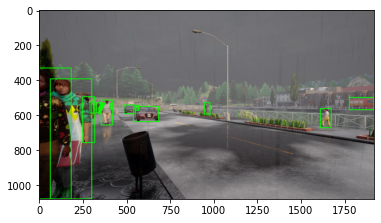

In [35]:
import matplotlib.pyplot as plt
plt.imshow(copy)

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [94]:
model = get_model_instance_segmentation(8)

In [95]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001,
                            momentum=0.9)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_loader, device=device)

Epoch: [0]  [    0/61788]  eta: 10 days, 19:24:25  lr: 0.000000  loss: 103.2217 (103.2217)  loss_classifier: 81.7747 (81.7747)  loss_box_reg: 0.6321 (0.6321)  loss_mask: 16.0842 (16.0842)  loss_objectness: 3.6583 (3.6583)  loss_rpn_box_reg: 1.0724 (1.0724)  time: 15.1140  data: 14.6484  max mem: 4422
Epoch: [0]  [   10/61788]  eta: 1 day, 6:04:47  lr: 0.000001  loss: 37.5317 (49.9976)  loss_classifier: 2.8806 (21.7821)  loss_box_reg: 0.4702 (0.7137)  loss_mask: 10.8247 (15.3763)  loss_objectness: 8.2405 (10.1629)  loss_rpn_box_reg: 0.8064 (1.9627)  time: 1.7529  data: 1.3318  max mem: 4731
Epoch: [0]  [   20/61788]  eta: 19:19:56  lr: 0.000002  loss: 16.5434 (47.8623)  loss_classifier: 0.5903 (11.6020)  loss_box_reg: 0.3909 (0.5851)  loss_mask: 7.8315 (12.4800)  loss_objectness: 2.6181 (21.1224)  loss_rpn_box_reg: 0.5864 (2.0729)  time: 0.4274  data: 0.0002  max mem: 4731
Epoch: [0]  [   30/61788]  eta: 15:30:36  lr: 0.000003  loss: 13.4527 (38.6251)  loss_classifier: 0.2377 (8.0522)  

Epoch: [0]  [  290/61788]  eta: 10:56:07  lr: 0.000029  loss: 0.4629 (5.9908)  loss_classifier: 0.0937 (1.0461)  loss_box_reg: 0.0686 (0.2312)  loss_mask: 0.1205 (1.4682)  loss_objectness: 0.0580 (2.5912)  loss_rpn_box_reg: 0.0205 (0.6541)  time: 0.5858  data: 0.1525  max mem: 4751
Epoch: [0]  [  300/61788]  eta: 10:59:53  lr: 0.000030  loss: 0.4568 (5.8087)  loss_classifier: 0.1349 (1.0160)  loss_box_reg: 0.0963 (0.2270)  loss_mask: 0.0997 (1.4225)  loss_objectness: 0.0662 (2.5072)  loss_rpn_box_reg: 0.0441 (0.6360)  time: 0.7560  data: 0.3130  max mem: 4751
Epoch: [0]  [  310/61788]  eta: 10:56:33  lr: 0.000031  loss: 0.3648 (5.6452)  loss_classifier: 0.0947 (0.9883)  loss_box_reg: 0.0840 (0.2234)  loss_mask: 0.1098 (1.3839)  loss_objectness: 0.0586 (2.4288)  loss_rpn_box_reg: 0.0386 (0.6209)  time: 0.6498  data: 0.2248  max mem: 4751
Epoch: [0]  [  320/61788]  eta: 10:58:56  lr: 0.000032  loss: 0.4986 (5.4939)  loss_classifier: 0.1102 (0.9618)  loss_box_reg: 0.1005 (0.2203)  loss_ma

Epoch: [0]  [  580/61788]  eta: 10:33:17  lr: 0.000058  loss: 0.3928 (3.2662)  loss_classifier: 0.0758 (0.5827)  loss_box_reg: 0.0552 (0.1568)  loss_mask: 0.1083 (0.8069)  loss_objectness: 0.0518 (1.3338)  loss_rpn_box_reg: 0.0202 (0.3860)  time: 0.6312  data: 0.1853  max mem: 4753
Epoch: [0]  [  590/61788]  eta: 10:30:29  lr: 0.000059  loss: 0.5424 (3.2242)  loss_classifier: 0.0912 (0.5757)  loss_box_reg: 0.0714 (0.1561)  loss_mask: 0.1239 (0.7954)  loss_objectness: 0.0661 (1.3134)  loss_rpn_box_reg: 0.0405 (0.3836)  time: 0.6320  data: 0.1853  max mem: 4753
Epoch: [0]  [  600/61788]  eta: 10:31:25  lr: 0.000060  loss: 0.4684 (3.1767)  loss_classifier: 0.1074 (0.5678)  loss_box_reg: 0.0659 (0.1546)  loss_mask: 0.0942 (0.7835)  loss_objectness: 0.0686 (1.2926)  loss_rpn_box_reg: 0.0333 (0.3782)  time: 0.5721  data: 0.1172  max mem: 4753
Epoch: [0]  [  610/61788]  eta: 10:41:22  lr: 0.000061  loss: 0.3482 (3.1338)  loss_classifier: 0.0819 (0.5602)  loss_box_reg: 0.0429 (0.1531)  loss_ma

Epoch: [0]  [  870/61788]  eta: 10:10:19  lr: 0.000087  loss: 0.3807 (2.3458)  loss_classifier: 0.1068 (0.4227)  loss_box_reg: 0.0657 (0.1261)  loss_mask: 0.0727 (0.5770)  loss_objectness: 0.0571 (0.9120)  loss_rpn_box_reg: 0.0429 (0.3080)  time: 0.4223  data: 0.0007  max mem: 4767
Epoch: [0]  [  880/61788]  eta: 10:15:39  lr: 0.000088  loss: 0.4780 (2.3254)  loss_classifier: 0.1097 (0.4192)  loss_box_reg: 0.0711 (0.1255)  loss_mask: 0.0904 (0.5721)  loss_objectness: 0.0749 (0.9032)  loss_rpn_box_reg: 0.0590 (0.3053)  time: 0.7453  data: 0.3401  max mem: 4767
Epoch: [0]  [  890/61788]  eta: 10:13:30  lr: 0.000089  loss: 0.4586 (2.3051)  loss_classifier: 0.1167 (0.4156)  loss_box_reg: 0.0752 (0.1250)  loss_mask: 0.0806 (0.5666)  loss_objectness: 0.0718 (0.8938)  loss_rpn_box_reg: 0.0273 (0.3041)  time: 0.7499  data: 0.3396  max mem: 4767
Epoch: [0]  [  900/61788]  eta: 10:11:42  lr: 0.000090  loss: 0.3022 (2.2845)  loss_classifier: 0.0835 (0.4121)  loss_box_reg: 0.0467 (0.1243)  loss_ma

Epoch: [0]  [ 1160/61788]  eta: 10:02:09  lr: 0.000100  loss: 0.3125 (1.9207)  loss_classifier: 0.0547 (0.3426)  loss_box_reg: 0.0266 (0.1119)  loss_mask: 0.1148 (0.4683)  loss_objectness: 0.0287 (0.7230)  loss_rpn_box_reg: 0.0114 (0.2749)  time: 0.4329  data: 0.0002  max mem: 4767
Epoch: [0]  [ 1170/61788]  eta: 10:04:03  lr: 0.000100  loss: 0.3141 (1.9076)  loss_classifier: 0.0679 (0.3405)  loss_box_reg: 0.0503 (0.1115)  loss_mask: 0.0797 (0.4654)  loss_objectness: 0.0316 (0.7171)  loss_rpn_box_reg: 0.0215 (0.2730)  time: 0.6252  data: 0.1946  max mem: 4767
Epoch: [0]  [ 1180/61788]  eta: 10:04:35  lr: 0.000100  loss: 0.3617 (1.8951)  loss_classifier: 0.0840 (0.3386)  loss_box_reg: 0.0557 (0.1112)  loss_mask: 0.0783 (0.4623)  loss_objectness: 0.0273 (0.7113)  loss_rpn_box_reg: 0.0280 (0.2716)  time: 0.7498  data: 0.3212  max mem: 4767
Epoch: [0]  [ 1190/61788]  eta: 10:07:41  lr: 0.000100  loss: 0.4094 (1.8885)  loss_classifier: 0.0840 (0.3372)  loss_box_reg: 0.0557 (0.1113)  loss_ma

Epoch: [0]  [ 1450/61788]  eta: 10:04:24  lr: 0.000100  loss: 0.2432 (1.6316)  loss_classifier: 0.0859 (0.2958)  loss_box_reg: 0.0424 (0.1032)  loss_mask: 0.0429 (0.3973)  loss_objectness: 0.0321 (0.5891)  loss_rpn_box_reg: 0.0183 (0.2463)  time: 0.4744  data: 0.0484  max mem: 4790
Epoch: [0]  [ 1460/61788]  eta: 10:04:41  lr: 0.000100  loss: 0.3216 (1.6241)  loss_classifier: 0.0904 (0.2944)  loss_box_reg: 0.0474 (0.1029)  loss_mask: 0.0475 (0.3952)  loss_objectness: 0.0321 (0.5853)  loss_rpn_box_reg: 0.0220 (0.2463)  time: 0.5968  data: 0.1717  max mem: 4790
Epoch: [0]  [ 1470/61788]  eta: 10:03:19  lr: 0.000100  loss: 0.3429 (1.6156)  loss_classifier: 0.0722 (0.2930)  loss_box_reg: 0.0424 (0.1025)  loss_mask: 0.0626 (0.3931)  loss_objectness: 0.0360 (0.5816)  loss_rpn_box_reg: 0.0233 (0.2454)  time: 0.5362  data: 0.1235  max mem: 4790
Epoch: [0]  [ 1480/61788]  eta: 10:02:08  lr: 0.000100  loss: 0.3258 (1.6075)  loss_classifier: 0.0718 (0.2918)  loss_box_reg: 0.0385 (0.1023)  loss_ma

Epoch: [0]  [ 1740/61788]  eta: 10:06:44  lr: 0.000100  loss: 0.3804 (1.4297)  loss_classifier: 0.0954 (0.2641)  loss_box_reg: 0.0610 (0.0969)  loss_mask: 0.0607 (0.3449)  loss_objectness: 0.0287 (0.4985)  loss_rpn_box_reg: 0.0278 (0.2253)  time: 0.4449  data: 0.0002  max mem: 4807
Epoch: [0]  [ 1750/61788]  eta: 10:08:14  lr: 0.000100  loss: 0.3804 (1.4245)  loss_classifier: 0.0859 (0.2633)  loss_box_reg: 0.0552 (0.0967)  loss_mask: 0.0494 (0.3432)  loss_objectness: 0.0318 (0.4959)  loss_rpn_box_reg: 0.0922 (0.2254)  time: 0.6767  data: 0.2360  max mem: 4807
Epoch: [0]  [ 1760/61788]  eta: 10:06:58  lr: 0.000100  loss: 0.2933 (1.4182)  loss_classifier: 0.0788 (0.2623)  loss_box_reg: 0.0359 (0.0964)  loss_mask: 0.0494 (0.3416)  loss_objectness: 0.0247 (0.4933)  loss_rpn_box_reg: 0.0148 (0.2247)  time: 0.6436  data: 0.2359  max mem: 4807
Epoch: [0]  [ 1770/61788]  eta: 10:05:52  lr: 0.000100  loss: 0.2474 (1.4120)  loss_classifier: 0.0820 (0.2615)  loss_box_reg: 0.0491 (0.0963)  loss_ma

Epoch: [0]  [ 2030/61788]  eta: 10:11:00  lr: 0.000100  loss: 0.3586 (1.2992)  loss_classifier: 0.1104 (0.2433)  loss_box_reg: 0.0718 (0.0937)  loss_mask: 0.0485 (0.3096)  loss_objectness: 0.0558 (0.4392)  loss_rpn_box_reg: 0.0207 (0.2135)  time: 0.6402  data: 0.2263  max mem: 4807
Epoch: [0]  [ 2040/61788]  eta: 10:10:01  lr: 0.000100  loss: 0.2800 (1.2947)  loss_classifier: 0.0794 (0.2425)  loss_box_reg: 0.0389 (0.0934)  loss_mask: 0.0569 (0.3085)  loss_objectness: 0.0512 (0.4373)  loss_rpn_box_reg: 0.0177 (0.2130)  time: 0.4205  data: 0.0002  max mem: 4807
Epoch: [0]  [ 2050/61788]  eta: 10:09:01  lr: 0.000100  loss: 0.2595 (1.2905)  loss_classifier: 0.0636 (0.2418)  loss_box_reg: 0.0306 (0.0932)  loss_mask: 0.0707 (0.3074)  loss_objectness: 0.0391 (0.4354)  loss_rpn_box_reg: 0.0180 (0.2126)  time: 0.4304  data: 0.0002  max mem: 4807
Epoch: [0]  [ 2060/61788]  eta: 10:08:04  lr: 0.000100  loss: 0.3024 (1.2857)  loss_classifier: 0.0808 (0.2411)  loss_box_reg: 0.0367 (0.0931)  loss_ma

Epoch: [0]  [ 2320/61788]  eta: 10:03:42  lr: 0.000100  loss: 0.2317 (1.1805)  loss_classifier: 0.0727 (0.2254)  loss_box_reg: 0.0341 (0.0893)  loss_mask: 0.0355 (0.2809)  loss_objectness: 0.0260 (0.3883)  loss_rpn_box_reg: 0.0177 (0.1966)  time: 0.5445  data: 0.1348  max mem: 4845
Epoch: [0]  [ 2330/61788]  eta: 10:04:57  lr: 0.000100  loss: 0.2863 (1.1782)  loss_classifier: 0.0861 (0.2248)  loss_box_reg: 0.0394 (0.0892)  loss_mask: 0.0335 (0.2799)  loss_objectness: 0.0316 (0.3874)  loss_rpn_box_reg: 0.0220 (0.1969)  time: 0.7954  data: 0.3918  max mem: 4845
Epoch: [0]  [ 2340/61788]  eta: 10:04:18  lr: 0.000100  loss: 0.3406 (1.1750)  loss_classifier: 0.0661 (0.2243)  loss_box_reg: 0.0366 (0.0890)  loss_mask: 0.0452 (0.2792)  loss_objectness: 0.0509 (0.3860)  loss_rpn_box_reg: 0.0237 (0.1966)  time: 0.7048  data: 0.2911  max mem: 4845
Epoch: [0]  [ 2350/61788]  eta: 10:04:24  lr: 0.000100  loss: 0.3845 (1.1718)  loss_classifier: 0.0595 (0.2236)  loss_box_reg: 0.0269 (0.0888)  loss_ma

Epoch: [0]  [ 2610/61788]  eta: 10:03:23  lr: 0.000100  loss: 0.3258 (1.0945)  loss_classifier: 0.0668 (0.2123)  loss_box_reg: 0.0289 (0.0864)  loss_mask: 0.0500 (0.2591)  loss_objectness: 0.0231 (0.3493)  loss_rpn_box_reg: 0.0136 (0.1874)  time: 0.6690  data: 0.2642  max mem: 4949
Epoch: [0]  [ 2620/61788]  eta: 10:03:57  lr: 0.000100  loss: 0.3562 (1.0921)  loss_classifier: 0.0741 (0.2120)  loss_box_reg: 0.0383 (0.0864)  loss_mask: 0.0613 (0.2586)  loss_objectness: 0.0285 (0.3481)  loss_rpn_box_reg: 0.0213 (0.1871)  time: 0.6010  data: 0.1793  max mem: 4949
Epoch: [0]  [ 2630/61788]  eta: 10:04:27  lr: 0.000100  loss: 0.4248 (1.0900)  loss_classifier: 0.1236 (0.2118)  loss_box_reg: 0.0812 (0.0864)  loss_mask: 0.0642 (0.2580)  loss_objectness: 0.0288 (0.3469)  loss_rpn_box_reg: 0.0223 (0.1869)  time: 0.7833  data: 0.3560  max mem: 4949
Epoch: [0]  [ 2640/61788]  eta: 10:03:38  lr: 0.000100  loss: 0.3127 (1.0875)  loss_classifier: 0.1236 (0.2115)  loss_box_reg: 0.0646 (0.0863)  loss_ma

Epoch: [0]  [ 2900/61788]  eta: 9:58:24  lr: 0.000100  loss: 0.2686 (1.0272)  loss_classifier: 0.0897 (0.2019)  loss_box_reg: 0.0400 (0.0839)  loss_mask: 0.0502 (0.2419)  loss_objectness: 0.0296 (0.3180)  loss_rpn_box_reg: 0.0129 (0.1815)  time: 0.6034  data: 0.1807  max mem: 4949
Epoch: [0]  [ 2910/61788]  eta: 9:57:44  lr: 0.000100  loss: 0.2540 (1.0255)  loss_classifier: 0.1023 (0.2017)  loss_box_reg: 0.0479 (0.0839)  loss_mask: 0.0468 (0.2412)  loss_objectness: 0.0301 (0.3171)  loss_rpn_box_reg: 0.0160 (0.1816)  time: 0.4335  data: 0.0002  max mem: 4949
Epoch: [0]  [ 2920/61788]  eta: 9:57:21  lr: 0.000100  loss: 0.2019 (1.0227)  loss_classifier: 0.0845 (0.2013)  loss_box_reg: 0.0440 (0.0837)  loss_mask: 0.0339 (0.2405)  loss_objectness: 0.0310 (0.3162)  loss_rpn_box_reg: 0.0124 (0.1810)  time: 0.4826  data: 0.0429  max mem: 4949
Epoch: [0]  [ 2930/61788]  eta: 9:56:46  lr: 0.000100  loss: 0.2294 (1.0220)  loss_classifier: 0.0803 (0.2009)  loss_box_reg: 0.0370 (0.0836)  loss_mask: 

Epoch: [0]  [ 3200/61788]  eta: 9:52:28  lr: 0.000100  loss: 0.3412 (0.9697)  loss_classifier: 0.1237 (0.1938)  loss_box_reg: 0.0784 (0.0821)  loss_mask: 0.0563 (0.2269)  loss_objectness: 0.0388 (0.2916)  loss_rpn_box_reg: 0.0175 (0.1753)  time: 0.4523  data: 0.0002  max mem: 4949
Epoch: [0]  [ 3210/61788]  eta: 9:52:46  lr: 0.000100  loss: 0.3462 (0.9678)  loss_classifier: 0.1053 (0.1936)  loss_box_reg: 0.0692 (0.0821)  loss_mask: 0.0366 (0.2265)  loss_objectness: 0.0256 (0.2907)  loss_rpn_box_reg: 0.0175 (0.1750)  time: 0.5980  data: 0.1568  max mem: 4949
Epoch: [0]  [ 3220/61788]  eta: 9:53:39  lr: 0.000100  loss: 0.3187 (0.9657)  loss_classifier: 0.0970 (0.1933)  loss_box_reg: 0.0475 (0.0820)  loss_mask: 0.0374 (0.2260)  loss_objectness: 0.0196 (0.2899)  loss_rpn_box_reg: 0.0175 (0.1745)  time: 0.8344  data: 0.4172  max mem: 4949
Epoch: [0]  [ 3230/61788]  eta: 9:53:02  lr: 0.000100  loss: 0.2883 (0.9639)  loss_classifier: 0.0895 (0.1931)  loss_box_reg: 0.0475 (0.0820)  loss_mask: 

Epoch: [0]  [ 3500/61788]  eta: 9:49:11  lr: 0.000100  loss: 0.3134 (0.9198)  loss_classifier: 0.1315 (0.1869)  loss_box_reg: 0.0739 (0.0805)  loss_mask: 0.0370 (0.2130)  loss_objectness: 0.0235 (0.2695)  loss_rpn_box_reg: 0.0229 (0.1698)  time: 0.8521  data: 0.4290  max mem: 4949
Epoch: [0]  [ 3510/61788]  eta: 9:48:37  lr: 0.000100  loss: 0.3078 (0.9180)  loss_classifier: 0.1038 (0.1867)  loss_box_reg: 0.0658 (0.0804)  loss_mask: 0.0435 (0.2126)  loss_objectness: 0.0303 (0.2689)  loss_rpn_box_reg: 0.0229 (0.1695)  time: 0.7705  data: 0.3453  max mem: 4949
Epoch: [0]  [ 3520/61788]  eta: 9:48:05  lr: 0.000100  loss: 0.2954 (0.9164)  loss_classifier: 0.0996 (0.1865)  loss_box_reg: 0.0576 (0.0804)  loss_mask: 0.0435 (0.2122)  loss_objectness: 0.0303 (0.2682)  loss_rpn_box_reg: 0.0169 (0.1692)  time: 0.4436  data: 0.0002  max mem: 4949
Epoch: [0]  [ 3530/61788]  eta: 9:47:42  lr: 0.000100  loss: 0.2954 (0.9147)  loss_classifier: 0.0991 (0.1862)  loss_box_reg: 0.0525 (0.0803)  loss_mask: 

Epoch: [0]  [ 3800/61788]  eta: 9:44:38  lr: 0.000100  loss: 0.3350 (0.8789)  loss_classifier: 0.0877 (0.1817)  loss_box_reg: 0.0526 (0.0796)  loss_mask: 0.0431 (0.2016)  loss_objectness: 0.0242 (0.2507)  loss_rpn_box_reg: 0.0406 (0.1653)  time: 0.4440  data: 0.0002  max mem: 4949
Epoch: [0]  [ 3810/61788]  eta: 9:44:17  lr: 0.000100  loss: 0.3521 (0.8791)  loss_classifier: 0.1145 (0.1816)  loss_box_reg: 0.0675 (0.0796)  loss_mask: 0.0330 (0.2014)  loss_objectness: 0.0233 (0.2501)  loss_rpn_box_reg: 0.0267 (0.1663)  time: 0.4804  data: 0.0313  max mem: 4949
Epoch: [0]  [ 3820/61788]  eta: 9:43:51  lr: 0.000100  loss: 0.4258 (0.8781)  loss_classifier: 0.0947 (0.1814)  loss_box_reg: 0.0558 (0.0796)  loss_mask: 0.0580 (0.2011)  loss_objectness: 0.0225 (0.2496)  loss_rpn_box_reg: 0.0267 (0.1665)  time: 0.4894  data: 0.0313  max mem: 4949
Epoch: [0]  [ 3830/61788]  eta: 9:43:20  lr: 0.000100  loss: 0.3150 (0.8768)  loss_classifier: 0.0912 (0.1812)  loss_box_reg: 0.0421 (0.0795)  loss_mask: 

Epoch: [0]  [ 4100/61788]  eta: 9:43:52  lr: 0.000100  loss: 0.3672 (0.8467)  loss_classifier: 0.1433 (0.1781)  loss_box_reg: 0.0939 (0.0793)  loss_mask: 0.0700 (0.1927)  loss_objectness: 0.0233 (0.2347)  loss_rpn_box_reg: 0.0150 (0.1618)  time: 0.4590  data: 0.0002  max mem: 4949
Epoch: [0]  [ 4110/61788]  eta: 9:43:57  lr: 0.000100  loss: 0.3931 (0.8461)  loss_classifier: 0.1161 (0.1780)  loss_box_reg: 0.0755 (0.0794)  loss_mask: 0.0765 (0.1924)  loss_objectness: 0.0274 (0.2343)  loss_rpn_box_reg: 0.0170 (0.1620)  time: 0.5807  data: 0.1424  max mem: 4949
Epoch: [0]  [ 4120/61788]  eta: 9:43:24  lr: 0.000100  loss: 0.3931 (0.8447)  loss_classifier: 0.0885 (0.1778)  loss_box_reg: 0.0547 (0.0793)  loss_mask: 0.0512 (0.1921)  loss_objectness: 0.0258 (0.2338)  loss_rpn_box_reg: 0.0271 (0.1617)  time: 0.5502  data: 0.1423  max mem: 4949
Epoch: [0]  [ 4130/61788]  eta: 9:42:53  lr: 0.000100  loss: 0.2930 (0.8435)  loss_classifier: 0.0661 (0.1776)  loss_box_reg: 0.0284 (0.0792)  loss_mask: 

Epoch: [0]  [ 4400/61788]  eta: 9:38:08  lr: 0.000100  loss: 0.3627 (0.8167)  loss_classifier: 0.1054 (0.1740)  loss_box_reg: 0.0585 (0.0786)  loss_mask: 0.0521 (0.1843)  loss_objectness: 0.0270 (0.2213)  loss_rpn_box_reg: 0.0268 (0.1586)  time: 0.5654  data: 0.1143  max mem: 4949
Epoch: [0]  [ 4410/61788]  eta: 9:38:47  lr: 0.000100  loss: 0.3627 (0.8158)  loss_classifier: 0.1091 (0.1739)  loss_box_reg: 0.0780 (0.0786)  loss_mask: 0.0617 (0.1841)  loss_objectness: 0.0277 (0.2209)  loss_rpn_box_reg: 0.0268 (0.1585)  time: 0.8127  data: 0.3730  max mem: 4949
Epoch: [0]  [ 4420/61788]  eta: 9:38:16  lr: 0.000100  loss: 0.3591 (0.8149)  loss_classifier: 0.1091 (0.1737)  loss_box_reg: 0.0663 (0.0785)  loss_mask: 0.0388 (0.1838)  loss_objectness: 0.0381 (0.2205)  loss_rpn_box_reg: 0.0231 (0.1584)  time: 0.6839  data: 0.2589  max mem: 4949
Epoch: [0]  [ 4430/61788]  eta: 9:37:56  lr: 0.000100  loss: 0.3756 (0.8140)  loss_classifier: 0.1132 (0.1737)  loss_box_reg: 0.0685 (0.0785)  loss_mask: 

Epoch: [0]  [ 4700/61788]  eta: 9:36:57  lr: 0.000100  loss: 0.3277 (0.7889)  loss_classifier: 0.1073 (0.1710)  loss_box_reg: 0.0701 (0.0783)  loss_mask: 0.0604 (0.1765)  loss_objectness: 0.0197 (0.2093)  loss_rpn_box_reg: 0.0116 (0.1539)  time: 0.4520  data: 0.0015  max mem: 4949
Epoch: [0]  [ 4710/61788]  eta: 9:36:37  lr: 0.000100  loss: 0.3852 (0.7884)  loss_classifier: 0.0836 (0.1709)  loss_box_reg: 0.0534 (0.0782)  loss_mask: 0.0439 (0.1763)  loss_objectness: 0.0201 (0.2089)  loss_rpn_box_reg: 0.0170 (0.1541)  time: 0.4754  data: 0.0106  max mem: 4949
Epoch: [0]  [ 4720/61788]  eta: 9:36:13  lr: 0.000100  loss: 0.3697 (0.7873)  loss_classifier: 0.0899 (0.1707)  loss_box_reg: 0.0412 (0.0782)  loss_mask: 0.0368 (0.1760)  loss_objectness: 0.0242 (0.2085)  loss_rpn_box_reg: 0.0307 (0.1539)  time: 0.4745  data: 0.0093  max mem: 4949
Epoch: [0]  [ 4730/61788]  eta: 9:35:48  lr: 0.000100  loss: 0.2911 (0.7869)  loss_classifier: 0.0899 (0.1706)  loss_box_reg: 0.0546 (0.0782)  loss_mask: 

Epoch: [0]  [ 5000/61788]  eta: 9:33:25  lr: 0.000100  loss: 0.3541 (0.7663)  loss_classifier: 0.1179 (0.1681)  loss_box_reg: 0.0618 (0.0777)  loss_mask: 0.0454 (0.1704)  loss_objectness: 0.0230 (0.1987)  loss_rpn_box_reg: 0.0171 (0.1514)  time: 0.7225  data: 0.2736  max mem: 4949
Epoch: [0]  [ 5010/61788]  eta: 9:33:06  lr: 0.000100  loss: 0.3507 (0.7657)  loss_classifier: 0.0764 (0.1680)  loss_box_reg: 0.0373 (0.0776)  loss_mask: 0.0725 (0.1704)  loss_objectness: 0.0245 (0.1984)  loss_rpn_box_reg: 0.0171 (0.1513)  time: 0.7337  data: 0.2994  max mem: 4949
Epoch: [0]  [ 5020/61788]  eta: 9:32:42  lr: 0.000100  loss: 0.3233 (0.7655)  loss_classifier: 0.0842 (0.1680)  loss_box_reg: 0.0510 (0.0777)  loss_mask: 0.0461 (0.1701)  loss_objectness: 0.0329 (0.1980)  loss_rpn_box_reg: 0.0218 (0.1517)  time: 0.4711  data: 0.0392  max mem: 4949
Epoch: [0]  [ 5030/61788]  eta: 9:32:17  lr: 0.000100  loss: 0.3234 (0.7652)  loss_classifier: 0.0842 (0.1679)  loss_box_reg: 0.0510 (0.0776)  loss_mask: 

Epoch: [0]  [ 5300/61788]  eta: 9:27:09  lr: 0.000100  loss: 0.3344 (0.7468)  loss_classifier: 0.0994 (0.1656)  loss_box_reg: 0.0636 (0.0773)  loss_mask: 0.0563 (0.1647)  loss_objectness: 0.0213 (0.1892)  loss_rpn_box_reg: 0.0231 (0.1500)  time: 0.4360  data: 0.0002  max mem: 4949
Epoch: [0]  [ 5310/61788]  eta: 9:26:47  lr: 0.000100  loss: 0.3208 (0.7459)  loss_classifier: 0.1177 (0.1655)  loss_box_reg: 0.0752 (0.0773)  loss_mask: 0.0304 (0.1645)  loss_objectness: 0.0155 (0.1889)  loss_rpn_box_reg: 0.0234 (0.1498)  time: 0.4431  data: 0.0002  max mem: 4949
Epoch: [0]  [ 5320/61788]  eta: 9:26:29  lr: 0.000100  loss: 0.2893 (0.7451)  loss_classifier: 0.1023 (0.1654)  loss_box_reg: 0.0752 (0.0772)  loss_mask: 0.0259 (0.1643)  loss_objectness: 0.0170 (0.1886)  loss_rpn_box_reg: 0.0234 (0.1496)  time: 0.4670  data: 0.0211  max mem: 4949
Epoch: [0]  [ 5330/61788]  eta: 9:26:26  lr: 0.000100  loss: 0.2452 (0.7445)  loss_classifier: 0.1004 (0.1653)  loss_box_reg: 0.0535 (0.0772)  loss_mask: 

Epoch: [0]  [ 5600/61788]  eta: 9:24:34  lr: 0.000100  loss: 0.3931 (0.7288)  loss_classifier: 0.1167 (0.1635)  loss_box_reg: 0.0621 (0.0770)  loss_mask: 0.0362 (0.1599)  loss_objectness: 0.0231 (0.1806)  loss_rpn_box_reg: 0.0457 (0.1479)  time: 0.7595  data: 0.3421  max mem: 4949
Epoch: [0]  [ 5610/61788]  eta: 9:24:50  lr: 0.000100  loss: 0.3236 (0.7281)  loss_classifier: 0.1167 (0.1635)  loss_box_reg: 0.0707 (0.0770)  loss_mask: 0.0329 (0.1597)  loss_objectness: 0.0201 (0.1803)  loss_rpn_box_reg: 0.0206 (0.1476)  time: 0.7590  data: 0.3469  max mem: 4949
Epoch: [0]  [ 5620/61788]  eta: 9:24:26  lr: 0.000100  loss: 0.3282 (0.7276)  loss_classifier: 0.1163 (0.1634)  loss_box_reg: 0.0707 (0.0770)  loss_mask: 0.0381 (0.1595)  loss_objectness: 0.0210 (0.1801)  loss_rpn_box_reg: 0.0196 (0.1476)  time: 0.6220  data: 0.2041  max mem: 4949
Epoch: [0]  [ 5630/61788]  eta: 9:24:35  lr: 0.000100  loss: 0.2785 (0.7270)  loss_classifier: 0.1028 (0.1633)  loss_box_reg: 0.0543 (0.0770)  loss_mask: 

Epoch: [0]  [ 5900/61788]  eta: 9:19:45  lr: 0.000100  loss: 0.2515 (0.7109)  loss_classifier: 0.0595 (0.1616)  loss_box_reg: 0.0286 (0.0767)  loss_mask: 0.0264 (0.1550)  loss_objectness: 0.0239 (0.1726)  loss_rpn_box_reg: 0.0155 (0.1450)  time: 0.4518  data: 0.0002  max mem: 4949
Epoch: [0]  [ 5910/61788]  eta: 9:19:45  lr: 0.000100  loss: 0.2500 (0.7103)  loss_classifier: 0.0981 (0.1615)  loss_box_reg: 0.0522 (0.0767)  loss_mask: 0.0264 (0.1548)  loss_objectness: 0.0217 (0.1724)  loss_rpn_box_reg: 0.0126 (0.1449)  time: 0.5666  data: 0.1049  max mem: 4949
Epoch: [0]  [ 5920/61788]  eta: 9:19:34  lr: 0.000100  loss: 0.2374 (0.7096)  loss_classifier: 0.0948 (0.1614)  loss_box_reg: 0.0425 (0.0766)  loss_mask: 0.0303 (0.1547)  loss_objectness: 0.0177 (0.1721)  loss_rpn_box_reg: 0.0142 (0.1447)  time: 0.6015  data: 0.1435  max mem: 4949
Epoch: [0]  [ 5930/61788]  eta: 9:20:09  lr: 0.000100  loss: 0.3543 (0.7093)  loss_classifier: 0.1146 (0.1615)  loss_box_reg: 0.0425 (0.0767)  loss_mask: 

Epoch: [0]  [ 6200/61788]  eta: 9:17:04  lr: 0.000100  loss: 0.2843 (0.6959)  loss_classifier: 0.1065 (0.1599)  loss_box_reg: 0.0620 (0.0763)  loss_mask: 0.0212 (0.1508)  loss_objectness: 0.0182 (0.1656)  loss_rpn_box_reg: 0.0179 (0.1432)  time: 0.9621  data: 0.5349  max mem: 4965
Epoch: [0]  [ 6210/61788]  eta: 9:16:49  lr: 0.000100  loss: 0.3696 (0.6957)  loss_classifier: 0.1485 (0.1601)  loss_box_reg: 0.0736 (0.0764)  loss_mask: 0.0296 (0.1506)  loss_objectness: 0.0234 (0.1654)  loss_rpn_box_reg: 0.0214 (0.1431)  time: 0.4546  data: 0.0001  max mem: 5305
Epoch: [0]  [ 6220/61788]  eta: 9:16:29  lr: 0.000100  loss: 0.2961 (0.6952)  loss_classifier: 0.1442 (0.1601)  loss_box_reg: 0.0699 (0.0764)  loss_mask: 0.0374 (0.1504)  loss_objectness: 0.0196 (0.1652)  loss_rpn_box_reg: 0.0181 (0.1431)  time: 0.4726  data: 0.0002  max mem: 5305
Epoch: [0]  [ 6230/61788]  eta: 9:16:42  lr: 0.000100  loss: 0.2879 (0.6946)  loss_classifier: 0.1185 (0.1600)  loss_box_reg: 0.0620 (0.0764)  loss_mask: 

Epoch: [0]  [ 6500/61788]  eta: 9:12:34  lr: 0.000100  loss: 0.4061 (0.6819)  loss_classifier: 0.0937 (0.1588)  loss_box_reg: 0.0516 (0.0761)  loss_mask: 0.0405 (0.1465)  loss_objectness: 0.0166 (0.1592)  loss_rpn_box_reg: 0.0260 (0.1413)  time: 0.5370  data: 0.0905  max mem: 5305
Epoch: [0]  [ 6510/61788]  eta: 9:12:48  lr: 0.000100  loss: 0.4061 (0.6813)  loss_classifier: 0.0970 (0.1587)  loss_box_reg: 0.0516 (0.0761)  loss_mask: 0.0496 (0.1464)  loss_objectness: 0.0195 (0.1590)  loss_rpn_box_reg: 0.0254 (0.1411)  time: 0.6558  data: 0.2040  max mem: 5305
Epoch: [0]  [ 6520/61788]  eta: 9:12:38  lr: 0.000100  loss: 0.2135 (0.6806)  loss_classifier: 0.0970 (0.1586)  loss_box_reg: 0.0435 (0.0761)  loss_mask: 0.0311 (0.1462)  loss_objectness: 0.0195 (0.1588)  loss_rpn_box_reg: 0.0122 (0.1409)  time: 0.6967  data: 0.2674  max mem: 5305
Epoch: [0]  [ 6530/61788]  eta: 9:12:35  lr: 0.000100  loss: 0.2135 (0.6801)  loss_classifier: 0.0955 (0.1586)  loss_box_reg: 0.0449 (0.0761)  loss_mask: 

Epoch: [0]  [ 6800/61788]  eta: 9:11:09  lr: 0.000100  loss: 0.3358 (0.6685)  loss_classifier: 0.0904 (0.1577)  loss_box_reg: 0.0508 (0.0761)  loss_mask: 0.0336 (0.1425)  loss_objectness: 0.0218 (0.1532)  loss_rpn_box_reg: 0.0184 (0.1390)  time: 0.6337  data: 0.1886  max mem: 5305
Epoch: [0]  [ 6810/61788]  eta: 9:11:21  lr: 0.000100  loss: 0.4361 (0.6683)  loss_classifier: 0.1689 (0.1578)  loss_box_reg: 0.0963 (0.0762)  loss_mask: 0.0559 (0.1424)  loss_objectness: 0.0271 (0.1530)  loss_rpn_box_reg: 0.0184 (0.1389)  time: 0.8295  data: 0.3891  max mem: 5305
Epoch: [0]  [ 6820/61788]  eta: 9:11:01  lr: 0.000100  loss: 0.4374 (0.6679)  loss_classifier: 0.1777 (0.1578)  loss_box_reg: 0.0963 (0.0762)  loss_mask: 0.0543 (0.1423)  loss_objectness: 0.0242 (0.1528)  loss_rpn_box_reg: 0.0231 (0.1389)  time: 0.6285  data: 0.2006  max mem: 5305
Epoch: [0]  [ 6830/61788]  eta: 9:10:40  lr: 0.000100  loss: 0.4270 (0.6677)  loss_classifier: 0.1238 (0.1577)  loss_box_reg: 0.0453 (0.0762)  loss_mask: 

Epoch: [0]  [ 7100/61788]  eta: 9:08:24  lr: 0.000100  loss: 0.2922 (0.6567)  loss_classifier: 0.1168 (0.1565)  loss_box_reg: 0.0565 (0.0759)  loss_mask: 0.0367 (0.1392)  loss_objectness: 0.0172 (0.1477)  loss_rpn_box_reg: 0.0157 (0.1373)  time: 0.4455  data: 0.0002  max mem: 5305
Epoch: [0]  [ 7110/61788]  eta: 9:08:19  lr: 0.000100  loss: 0.2808 (0.6562)  loss_classifier: 0.1168 (0.1565)  loss_box_reg: 0.0565 (0.0759)  loss_mask: 0.0334 (0.1391)  loss_objectness: 0.0200 (0.1476)  loss_rpn_box_reg: 0.0129 (0.1371)  time: 0.5179  data: 0.0862  max mem: 5305
Epoch: [0]  [ 7120/61788]  eta: 9:08:01  lr: 0.000100  loss: 0.2861 (0.6557)  loss_classifier: 0.1401 (0.1565)  loss_box_reg: 0.0784 (0.0759)  loss_mask: 0.0337 (0.1390)  loss_objectness: 0.0171 (0.1474)  loss_rpn_box_reg: 0.0103 (0.1370)  time: 0.5299  data: 0.0862  max mem: 5305
Epoch: [0]  [ 7130/61788]  eta: 9:07:51  lr: 0.000100  loss: 0.2418 (0.6553)  loss_classifier: 0.0893 (0.1565)  loss_box_reg: 0.0489 (0.0759)  loss_mask: 

Epoch: [0]  [ 7400/61788]  eta: 9:07:37  lr: 0.000100  loss: 0.1938 (0.6459)  loss_classifier: 0.0746 (0.1559)  loss_box_reg: 0.0380 (0.0760)  loss_mask: 0.0269 (0.1356)  loss_objectness: 0.0187 (0.1428)  loss_rpn_box_reg: 0.0094 (0.1357)  time: 0.5474  data: 0.1224  max mem: 5305
Epoch: [0]  [ 7410/61788]  eta: 9:07:27  lr: 0.000100  loss: 0.2049 (0.6455)  loss_classifier: 0.0930 (0.1558)  loss_box_reg: 0.0505 (0.0760)  loss_mask: 0.0269 (0.1355)  loss_objectness: 0.0149 (0.1426)  loss_rpn_box_reg: 0.0113 (0.1356)  time: 0.4818  data: 0.0751  max mem: 5305
Epoch: [0]  [ 7420/61788]  eta: 9:07:09  lr: 0.000100  loss: 0.3564 (0.6453)  loss_classifier: 0.1085 (0.1558)  loss_box_reg: 0.0553 (0.0760)  loss_mask: 0.0564 (0.1354)  loss_objectness: 0.0180 (0.1424)  loss_rpn_box_reg: 0.0213 (0.1355)  time: 0.4992  data: 0.0841  max mem: 5305
Epoch: [0]  [ 7430/61788]  eta: 9:07:05  lr: 0.000100  loss: 0.3020 (0.6448)  loss_classifier: 0.0987 (0.1557)  loss_box_reg: 0.0435 (0.0760)  loss_mask: 

Epoch: [0]  [ 7700/61788]  eta: 9:06:41  lr: 0.000100  loss: 0.3161 (0.6371)  loss_classifier: 0.1206 (0.1553)  loss_box_reg: 0.0623 (0.0761)  loss_mask: 0.0308 (0.1326)  loss_objectness: 0.0216 (0.1381)  loss_rpn_box_reg: 0.0199 (0.1350)  time: 0.8826  data: 0.4689  max mem: 5305
Epoch: [0]  [ 7710/61788]  eta: 9:06:21  lr: 0.000100  loss: 0.3122 (0.6367)  loss_classifier: 0.1052 (0.1552)  loss_box_reg: 0.0502 (0.0761)  loss_mask: 0.0346 (0.1326)  loss_objectness: 0.0179 (0.1380)  loss_rpn_box_reg: 0.0119 (0.1349)  time: 0.7118  data: 0.3054  max mem: 5305
Epoch: [0]  [ 7720/61788]  eta: 9:06:24  lr: 0.000100  loss: 0.2433 (0.6364)  loss_classifier: 0.1042 (0.1552)  loss_box_reg: 0.0502 (0.0761)  loss_mask: 0.0421 (0.1324)  loss_objectness: 0.0188 (0.1378)  loss_rpn_box_reg: 0.0119 (0.1349)  time: 0.5721  data: 0.1683  max mem: 5305
Epoch: [0]  [ 7730/61788]  eta: 9:06:30  lr: 0.000100  loss: 0.2554 (0.6360)  loss_classifier: 0.1058 (0.1551)  loss_box_reg: 0.0401 (0.0760)  loss_mask: 

Epoch: [0]  [ 8000/61788]  eta: 9:02:28  lr: 0.000100  loss: 0.3184 (0.6269)  loss_classifier: 0.0778 (0.1540)  loss_box_reg: 0.0562 (0.0757)  loss_mask: 0.0429 (0.1302)  loss_objectness: 0.0179 (0.1339)  loss_rpn_box_reg: 0.0216 (0.1331)  time: 0.6765  data: 0.2588  max mem: 5305
Epoch: [0]  [ 8010/61788]  eta: 9:02:21  lr: 0.000100  loss: 0.2914 (0.6266)  loss_classifier: 0.0934 (0.1540)  loss_box_reg: 0.0562 (0.0757)  loss_mask: 0.0255 (0.1301)  loss_objectness: 0.0179 (0.1338)  loss_rpn_box_reg: 0.0166 (0.1330)  time: 0.5053  data: 0.0772  max mem: 5305
Epoch: [0]  [ 8020/61788]  eta: 9:02:16  lr: 0.000100  loss: 0.3423 (0.6263)  loss_classifier: 0.1344 (0.1540)  loss_box_reg: 0.0715 (0.0757)  loss_mask: 0.0264 (0.1300)  loss_objectness: 0.0221 (0.1336)  loss_rpn_box_reg: 0.0166 (0.1330)  time: 0.6113  data: 0.1784  max mem: 5305
Epoch: [0]  [ 8030/61788]  eta: 9:01:58  lr: 0.000100  loss: 0.3423 (0.6259)  loss_classifier: 0.1142 (0.1540)  loss_box_reg: 0.0627 (0.0757)  loss_mask: 

Epoch: [0]  [ 8300/61788]  eta: 8:57:52  lr: 0.000100  loss: 0.2912 (0.6175)  loss_classifier: 0.0789 (0.1534)  loss_box_reg: 0.0281 (0.0758)  loss_mask: 0.0455 (0.1274)  loss_objectness: 0.0246 (0.1298)  loss_rpn_box_reg: 0.0169 (0.1310)  time: 0.4354  data: 0.0002  max mem: 5305
Epoch: [0]  [ 8310/61788]  eta: 8:57:36  lr: 0.000100  loss: 0.2431 (0.6170)  loss_classifier: 0.0843 (0.1534)  loss_box_reg: 0.0504 (0.0758)  loss_mask: 0.0407 (0.1273)  loss_objectness: 0.0236 (0.1297)  loss_rpn_box_reg: 0.0159 (0.1308)  time: 0.4417  data: 0.0002  max mem: 5305
Epoch: [0]  [ 8320/61788]  eta: 8:57:28  lr: 0.000100  loss: 0.2058 (0.6166)  loss_classifier: 0.0790 (0.1533)  loss_box_reg: 0.0407 (0.0758)  loss_mask: 0.0337 (0.1272)  loss_objectness: 0.0211 (0.1296)  loss_rpn_box_reg: 0.0159 (0.1307)  time: 0.5106  data: 0.0609  max mem: 5305
Epoch: [0]  [ 8330/61788]  eta: 8:57:49  lr: 0.000100  loss: 0.2466 (0.6163)  loss_classifier: 0.1088 (0.1533)  loss_box_reg: 0.0499 (0.0758)  loss_mask: 

Epoch: [0]  [ 8600/61788]  eta: 8:54:25  lr: 0.000100  loss: 0.2084 (0.6092)  loss_classifier: 0.0699 (0.1525)  loss_box_reg: 0.0382 (0.0757)  loss_mask: 0.0220 (0.1253)  loss_objectness: 0.0125 (0.1261)  loss_rpn_box_reg: 0.0090 (0.1296)  time: 0.6509  data: 0.2231  max mem: 5305
Epoch: [0]  [ 8610/61788]  eta: 8:54:43  lr: 0.000100  loss: 0.3597 (0.6089)  loss_classifier: 0.1202 (0.1525)  loss_box_reg: 0.0558 (0.0757)  loss_mask: 0.0250 (0.1253)  loss_objectness: 0.0201 (0.1259)  loss_rpn_box_reg: 0.0110 (0.1295)  time: 0.7483  data: 0.3246  max mem: 5305
Epoch: [0]  [ 8620/61788]  eta: 8:54:26  lr: 0.000100  loss: 0.3839 (0.6087)  loss_classifier: 0.1298 (0.1525)  loss_box_reg: 0.1000 (0.0757)  loss_mask: 0.0317 (0.1252)  loss_objectness: 0.0178 (0.1258)  loss_rpn_box_reg: 0.0200 (0.1295)  time: 0.7088  data: 0.2915  max mem: 5305
Epoch: [0]  [ 8630/61788]  eta: 8:54:21  lr: 0.000100  loss: 0.3426 (0.6084)  loss_classifier: 0.1457 (0.1525)  loss_box_reg: 0.1000 (0.0757)  loss_mask: 

Epoch: [0]  [ 8900/61788]  eta: 8:53:03  lr: 0.000100  loss: 0.3580 (0.6022)  loss_classifier: 0.1214 (0.1522)  loss_box_reg: 0.0761 (0.0758)  loss_mask: 0.0205 (0.1230)  loss_objectness: 0.0166 (0.1225)  loss_rpn_box_reg: 0.0235 (0.1286)  time: 0.7461  data: 0.3191  max mem: 5305
Epoch: [0]  [ 8910/61788]  eta: 8:52:58  lr: 0.000100  loss: 0.3580 (0.6021)  loss_classifier: 0.1402 (0.1521)  loss_box_reg: 0.0745 (0.0758)  loss_mask: 0.0518 (0.1231)  loss_objectness: 0.0197 (0.1224)  loss_rpn_box_reg: 0.0287 (0.1286)  time: 0.6882  data: 0.2678  max mem: 5305
Epoch: [0]  [ 8920/61788]  eta: 8:52:44  lr: 0.000100  loss: 0.3768 (0.6020)  loss_classifier: 0.1355 (0.1521)  loss_box_reg: 0.0770 (0.0758)  loss_mask: 0.0805 (0.1231)  loss_objectness: 0.0266 (0.1223)  loss_rpn_box_reg: 0.0525 (0.1286)  time: 0.5468  data: 0.1238  max mem: 5305
Epoch: [0]  [ 8930/61788]  eta: 8:52:51  lr: 0.000100  loss: 0.3719 (0.6017)  loss_classifier: 0.0872 (0.1521)  loss_box_reg: 0.0612 (0.0758)  loss_mask: 

Epoch: [0]  [ 9200/61788]  eta: 8:50:00  lr: 0.000100  loss: 0.3883 (0.5956)  loss_classifier: 0.1128 (0.1515)  loss_box_reg: 0.0664 (0.0757)  loss_mask: 0.0423 (0.1213)  loss_objectness: 0.0179 (0.1193)  loss_rpn_box_reg: 0.0257 (0.1279)  time: 0.7243  data: 0.2790  max mem: 5305
Epoch: [0]  [ 9210/61788]  eta: 8:49:59  lr: 0.000100  loss: 0.3883 (0.5954)  loss_classifier: 0.0998 (0.1515)  loss_box_reg: 0.0500 (0.0757)  loss_mask: 0.0462 (0.1212)  loss_objectness: 0.0202 (0.1192)  loss_rpn_box_reg: 0.0288 (0.1280)  time: 0.7128  data: 0.2823  max mem: 5305
Epoch: [0]  [ 9220/61788]  eta: 8:49:46  lr: 0.000100  loss: 0.2358 (0.5951)  loss_classifier: 0.0954 (0.1514)  loss_box_reg: 0.0419 (0.0757)  loss_mask: 0.0462 (0.1211)  loss_objectness: 0.0170 (0.1190)  loss_rpn_box_reg: 0.0120 (0.1278)  time: 0.5848  data: 0.1624  max mem: 5305
Epoch: [0]  [ 9230/61788]  eta: 8:50:00  lr: 0.000100  loss: 0.3246 (0.5950)  loss_classifier: 0.1338 (0.1514)  loss_box_reg: 0.0952 (0.0757)  loss_mask: 

Epoch: [0]  [ 9500/61788]  eta: 8:47:41  lr: 0.000100  loss: 0.2831 (0.5888)  loss_classifier: 0.0975 (0.1509)  loss_box_reg: 0.0503 (0.0757)  loss_mask: 0.0355 (0.1189)  loss_objectness: 0.0252 (0.1162)  loss_rpn_box_reg: 0.0136 (0.1271)  time: 0.5262  data: 0.0723  max mem: 5305
Epoch: [0]  [ 9510/61788]  eta: 8:47:43  lr: 0.000100  loss: 0.3080 (0.5886)  loss_classifier: 0.1396 (0.1510)  loss_box_reg: 0.0643 (0.0757)  loss_mask: 0.0371 (0.1189)  loss_objectness: 0.0160 (0.1161)  loss_rpn_box_reg: 0.0139 (0.1270)  time: 0.6962  data: 0.2251  max mem: 5305
Epoch: [0]  [ 9520/61788]  eta: 8:47:26  lr: 0.000100  loss: 0.3080 (0.5883)  loss_classifier: 0.1331 (0.1509)  loss_box_reg: 0.0523 (0.0757)  loss_mask: 0.0312 (0.1188)  loss_objectness: 0.0131 (0.1160)  loss_rpn_box_reg: 0.0132 (0.1269)  time: 0.5861  data: 0.1529  max mem: 5305
Epoch: [0]  [ 9530/61788]  eta: 8:47:14  lr: 0.000100  loss: 0.2245 (0.5880)  loss_classifier: 0.0700 (0.1508)  loss_box_reg: 0.0362 (0.0756)  loss_mask: 

Epoch: [0]  [ 9800/61788]  eta: 8:45:41  lr: 0.000100  loss: 0.2708 (0.5825)  loss_classifier: 0.1067 (0.1505)  loss_box_reg: 0.0395 (0.0756)  loss_mask: 0.0246 (0.1171)  loss_objectness: 0.0159 (0.1133)  loss_rpn_box_reg: 0.0312 (0.1261)  time: 0.7854  data: 0.3779  max mem: 5305
Epoch: [0]  [ 9810/61788]  eta: 8:45:28  lr: 0.000100  loss: 0.2761 (0.5822)  loss_classifier: 0.1182 (0.1504)  loss_box_reg: 0.0448 (0.0756)  loss_mask: 0.0249 (0.1170)  loss_objectness: 0.0140 (0.1132)  loss_rpn_box_reg: 0.0185 (0.1260)  time: 0.7194  data: 0.3230  max mem: 5305
Epoch: [0]  [ 9820/61788]  eta: 8:45:29  lr: 0.000100  loss: 0.2998 (0.5821)  loss_classifier: 0.1058 (0.1504)  loss_box_reg: 0.0526 (0.0756)  loss_mask: 0.0358 (0.1169)  loss_objectness: 0.0181 (0.1131)  loss_rpn_box_reg: 0.0187 (0.1260)  time: 0.6044  data: 0.2025  max mem: 5305
Epoch: [0]  [ 9830/61788]  eta: 8:45:36  lr: 0.000100  loss: 0.4202 (0.5819)  loss_classifier: 0.1087 (0.1504)  loss_box_reg: 0.0711 (0.0756)  loss_mask: 

Epoch: [0]  [10100/61788]  eta: 8:42:40  lr: 0.000100  loss: 0.2254 (0.5762)  loss_classifier: 0.1032 (0.1500)  loss_box_reg: 0.0416 (0.0756)  loss_mask: 0.0157 (0.1152)  loss_objectness: 0.0117 (0.1106)  loss_rpn_box_reg: 0.0086 (0.1248)  time: 0.4430  data: 0.0002  max mem: 5305
Epoch: [0]  [10110/61788]  eta: 8:42:26  lr: 0.000100  loss: 0.2510 (0.5759)  loss_classifier: 0.1097 (0.1500)  loss_box_reg: 0.0598 (0.0756)  loss_mask: 0.0368 (0.1152)  loss_objectness: 0.0150 (0.1105)  loss_rpn_box_reg: 0.0102 (0.1246)  time: 0.4463  data: 0.0002  max mem: 5305
Epoch: [0]  [10120/61788]  eta: 8:42:12  lr: 0.000100  loss: 0.2544 (0.5757)  loss_classifier: 0.1036 (0.1499)  loss_box_reg: 0.0583 (0.0756)  loss_mask: 0.0368 (0.1152)  loss_objectness: 0.0162 (0.1105)  loss_rpn_box_reg: 0.0106 (0.1246)  time: 0.4464  data: 0.0002  max mem: 5305
Epoch: [0]  [10130/61788]  eta: 8:42:04  lr: 0.000100  loss: 0.3535 (0.5755)  loss_classifier: 0.0743 (0.1499)  loss_box_reg: 0.0362 (0.0756)  loss_mask: 

Epoch: [0]  [10400/61788]  eta: 8:38:21  lr: 0.000100  loss: 0.3337 (0.5692)  loss_classifier: 0.1055 (0.1493)  loss_box_reg: 0.0566 (0.0754)  loss_mask: 0.0257 (0.1133)  loss_objectness: 0.0131 (0.1080)  loss_rpn_box_reg: 0.0178 (0.1232)  time: 0.7702  data: 0.3182  max mem: 5305
Epoch: [0]  [10410/61788]  eta: 8:38:21  lr: 0.000100  loss: 0.3237 (0.5690)  loss_classifier: 0.1272 (0.1493)  loss_box_reg: 0.0641 (0.0754)  loss_mask: 0.0274 (0.1132)  loss_objectness: 0.0135 (0.1079)  loss_rpn_box_reg: 0.0175 (0.1231)  time: 0.8979  data: 0.4588  max mem: 5305
Epoch: [0]  [10420/61788]  eta: 8:38:23  lr: 0.000100  loss: 0.3524 (0.5689)  loss_classifier: 0.1525 (0.1493)  loss_box_reg: 0.0675 (0.0754)  loss_mask: 0.0196 (0.1132)  loss_objectness: 0.0135 (0.1078)  loss_rpn_box_reg: 0.0251 (0.1231)  time: 0.7533  data: 0.3082  max mem: 5305
Epoch: [0]  [10430/61788]  eta: 8:38:26  lr: 0.000100  loss: 0.3024 (0.5686)  loss_classifier: 0.1347 (0.1493)  loss_box_reg: 0.0619 (0.0754)  loss_mask: 

Epoch: [0]  [10700/61788]  eta: 8:35:12  lr: 0.000100  loss: 0.3326 (0.5639)  loss_classifier: 0.0892 (0.1488)  loss_box_reg: 0.0381 (0.0752)  loss_mask: 0.0309 (0.1117)  loss_objectness: 0.0155 (0.1057)  loss_rpn_box_reg: 0.0165 (0.1225)  time: 0.4336  data: 0.0002  max mem: 5305
Epoch: [0]  [10710/61788]  eta: 8:35:01  lr: 0.000100  loss: 0.4174 (0.5638)  loss_classifier: 0.1182 (0.1488)  loss_box_reg: 0.0627 (0.0752)  loss_mask: 0.0775 (0.1117)  loss_objectness: 0.0186 (0.1056)  loss_rpn_box_reg: 0.0310 (0.1225)  time: 0.4691  data: 0.0216  max mem: 5305
Epoch: [0]  [10720/61788]  eta: 8:34:52  lr: 0.000100  loss: 0.3266 (0.5635)  loss_classifier: 0.1050 (0.1488)  loss_box_reg: 0.0627 (0.0752)  loss_mask: 0.0720 (0.1116)  loss_objectness: 0.0149 (0.1055)  loss_rpn_box_reg: 0.0145 (0.1224)  time: 0.5166  data: 0.0732  max mem: 5305
Epoch: [0]  [10730/61788]  eta: 8:34:47  lr: 0.000100  loss: 0.2272 (0.5633)  loss_classifier: 0.0966 (0.1488)  loss_box_reg: 0.0510 (0.0752)  loss_mask: 

Epoch: [0]  [11000/61788]  eta: 8:31:35  lr: 0.000100  loss: 0.1943 (0.5581)  loss_classifier: 0.0840 (0.1483)  loss_box_reg: 0.0507 (0.0750)  loss_mask: 0.0230 (0.1100)  loss_objectness: 0.0133 (0.1033)  loss_rpn_box_reg: 0.0095 (0.1214)  time: 0.4495  data: 0.0002  max mem: 5305
Epoch: [0]  [11010/61788]  eta: 8:31:23  lr: 0.000100  loss: 0.2372 (0.5579)  loss_classifier: 0.1057 (0.1483)  loss_box_reg: 0.0565 (0.0751)  loss_mask: 0.0356 (0.1100)  loss_objectness: 0.0147 (0.1033)  loss_rpn_box_reg: 0.0177 (0.1213)  time: 0.4549  data: 0.0002  max mem: 5305
Epoch: [0]  [11020/61788]  eta: 8:31:09  lr: 0.000100  loss: 0.2751 (0.5577)  loss_classifier: 0.1484 (0.1483)  loss_box_reg: 0.0728 (0.0751)  loss_mask: 0.0302 (0.1099)  loss_objectness: 0.0158 (0.1032)  loss_rpn_box_reg: 0.0133 (0.1212)  time: 0.4456  data: 0.0002  max mem: 5305
Epoch: [0]  [11030/61788]  eta: 8:31:24  lr: 0.000100  loss: 0.2256 (0.5574)  loss_classifier: 0.0734 (0.1482)  loss_box_reg: 0.0372 (0.0750)  loss_mask: 

Epoch: [0]  [11300/61788]  eta: 8:28:35  lr: 0.000100  loss: 0.2671 (0.5526)  loss_classifier: 0.1130 (0.1478)  loss_box_reg: 0.0640 (0.0749)  loss_mask: 0.0351 (0.1087)  loss_objectness: 0.0101 (0.1012)  loss_rpn_box_reg: 0.0139 (0.1200)  time: 0.4317  data: 0.0002  max mem: 5305
Epoch: [0]  [11310/61788]  eta: 8:28:22  lr: 0.000100  loss: 0.2594 (0.5524)  loss_classifier: 0.1130 (0.1478)  loss_box_reg: 0.0676 (0.0750)  loss_mask: 0.0249 (0.1086)  loss_objectness: 0.0119 (0.1011)  loss_rpn_box_reg: 0.0128 (0.1199)  time: 0.4431  data: 0.0002  max mem: 5305
Epoch: [0]  [11320/61788]  eta: 8:28:16  lr: 0.000100  loss: 0.3020 (0.5522)  loss_classifier: 0.1034 (0.1478)  loss_box_reg: 0.0460 (0.0749)  loss_mask: 0.0135 (0.1086)  loss_objectness: 0.0126 (0.1010)  loss_rpn_box_reg: 0.0146 (0.1200)  time: 0.5307  data: 0.0932  max mem: 5305
Epoch: [0]  [11330/61788]  eta: 8:28:02  lr: 0.000100  loss: 0.2465 (0.5520)  loss_classifier: 0.0877 (0.1477)  loss_box_reg: 0.0334 (0.0749)  loss_mask: 

Epoch: [0]  [11600/61788]  eta: 8:24:40  lr: 0.000100  loss: 0.4164 (0.5478)  loss_classifier: 0.1271 (0.1474)  loss_box_reg: 0.0749 (0.0748)  loss_mask: 0.0496 (0.1074)  loss_objectness: 0.0237 (0.0991)  loss_rpn_box_reg: 0.0421 (0.1192)  time: 0.4431  data: 0.0222  max mem: 5305
Epoch: [0]  [11610/61788]  eta: 8:24:41  lr: 0.000100  loss: 0.3352 (0.5477)  loss_classifier: 0.1203 (0.1474)  loss_box_reg: 0.0580 (0.0748)  loss_mask: 0.0554 (0.1074)  loss_objectness: 0.0196 (0.0990)  loss_rpn_box_reg: 0.0240 (0.1191)  time: 0.5885  data: 0.1844  max mem: 5305
Epoch: [0]  [11620/61788]  eta: 8:24:56  lr: 0.000100  loss: 0.3332 (0.5476)  loss_classifier: 0.0985 (0.1474)  loss_box_reg: 0.0477 (0.0748)  loss_mask: 0.0554 (0.1074)  loss_objectness: 0.0183 (0.0989)  loss_rpn_box_reg: 0.0240 (0.1191)  time: 0.9317  data: 0.5206  max mem: 5305
Epoch: [0]  [11630/61788]  eta: 8:24:42  lr: 0.000100  loss: 0.3355 (0.5474)  loss_classifier: 0.1204 (0.1474)  loss_box_reg: 0.0822 (0.0748)  loss_mask: 

Epoch: [0]  [11900/61788]  eta: 8:22:33  lr: 0.000100  loss: 0.3147 (0.5433)  loss_classifier: 0.1424 (0.1473)  loss_box_reg: 0.0815 (0.0749)  loss_mask: 0.0289 (0.1062)  loss_objectness: 0.0226 (0.0971)  loss_rpn_box_reg: 0.0129 (0.1178)  time: 0.5700  data: 0.1459  max mem: 5305
Epoch: [0]  [11910/61788]  eta: 8:22:32  lr: 0.000100  loss: 0.2548 (0.5431)  loss_classifier: 0.1185 (0.1473)  loss_box_reg: 0.0427 (0.0749)  loss_mask: 0.0245 (0.1061)  loss_objectness: 0.0199 (0.0971)  loss_rpn_box_reg: 0.0156 (0.1178)  time: 0.5702  data: 0.1543  max mem: 5305
Epoch: [0]  [11920/61788]  eta: 8:22:36  lr: 0.000100  loss: 0.2833 (0.5430)  loss_classifier: 0.1416 (0.1473)  loss_box_reg: 0.0630 (0.0749)  loss_mask: 0.0173 (0.1061)  loss_objectness: 0.0182 (0.0970)  loss_rpn_box_reg: 0.0211 (0.1178)  time: 0.7812  data: 0.3638  max mem: 5305
Epoch: [0]  [11930/61788]  eta: 8:22:23  lr: 0.000100  loss: 0.4821 (0.5430)  loss_classifier: 0.1879 (0.1473)  loss_box_reg: 0.1063 (0.0749)  loss_mask: 

Epoch: [0]  [12200/61788]  eta: 8:19:01  lr: 0.000100  loss: 0.3156 (0.5389)  loss_classifier: 0.1069 (0.1471)  loss_box_reg: 0.0594 (0.0749)  loss_mask: 0.0413 (0.1049)  loss_objectness: 0.0141 (0.0952)  loss_rpn_box_reg: 0.0182 (0.1168)  time: 0.4279  data: 0.0002  max mem: 5305
Epoch: [0]  [12210/61788]  eta: 8:18:51  lr: 0.000100  loss: 0.3361 (0.5388)  loss_classifier: 0.1036 (0.1471)  loss_box_reg: 0.0594 (0.0749)  loss_mask: 0.0440 (0.1049)  loss_objectness: 0.0172 (0.0952)  loss_rpn_box_reg: 0.0182 (0.1168)  time: 0.4730  data: 0.0313  max mem: 5305
Epoch: [0]  [12220/61788]  eta: 8:18:46  lr: 0.000100  loss: 0.3371 (0.5387)  loss_classifier: 0.0942 (0.1471)  loss_box_reg: 0.0333 (0.0749)  loss_mask: 0.0454 (0.1048)  loss_objectness: 0.0188 (0.0951)  loss_rpn_box_reg: 0.0275 (0.1168)  time: 0.5737  data: 0.1350  max mem: 5305
Epoch: [0]  [12230/61788]  eta: 8:18:33  lr: 0.000100  loss: 0.2677 (0.5385)  loss_classifier: 0.0869 (0.1471)  loss_box_reg: 0.0376 (0.0749)  loss_mask: 

Epoch: [0]  [12500/61788]  eta: 8:16:15  lr: 0.000100  loss: 0.2254 (0.5344)  loss_classifier: 0.1019 (0.1468)  loss_box_reg: 0.0403 (0.0748)  loss_mask: 0.0272 (0.1036)  loss_objectness: 0.0159 (0.0934)  loss_rpn_box_reg: 0.0192 (0.1156)  time: 0.7032  data: 0.2593  max mem: 5305
Epoch: [0]  [12510/61788]  eta: 8:16:09  lr: 0.000100  loss: 0.2302 (0.5342)  loss_classifier: 0.1199 (0.1469)  loss_box_reg: 0.0403 (0.0748)  loss_mask: 0.0222 (0.1036)  loss_objectness: 0.0156 (0.0934)  loss_rpn_box_reg: 0.0092 (0.1156)  time: 0.5688  data: 0.1151  max mem: 5305
Epoch: [0]  [12520/61788]  eta: 8:16:16  lr: 0.000100  loss: 0.3383 (0.5341)  loss_classifier: 0.1471 (0.1469)  loss_box_reg: 0.0765 (0.0748)  loss_mask: 0.0251 (0.1035)  loss_objectness: 0.0156 (0.0933)  loss_rpn_box_reg: 0.0170 (0.1155)  time: 0.7734  data: 0.3275  max mem: 5305
Epoch: [0]  [12530/61788]  eta: 8:16:23  lr: 0.000100  loss: 0.3305 (0.5339)  loss_classifier: 0.1412 (0.1469)  loss_box_reg: 0.0722 (0.0748)  loss_mask: 

Epoch: [0]  [12800/61788]  eta: 8:13:05  lr: 0.000100  loss: 0.2713 (0.5300)  loss_classifier: 0.0924 (0.1465)  loss_box_reg: 0.0388 (0.0748)  loss_mask: 0.0379 (0.1023)  loss_objectness: 0.0159 (0.0917)  loss_rpn_box_reg: 0.0149 (0.1146)  time: 0.4323  data: 0.0002  max mem: 5305
Epoch: [0]  [12810/61788]  eta: 8:12:54  lr: 0.000100  loss: 0.2994 (0.5298)  loss_classifier: 0.0924 (0.1465)  loss_box_reg: 0.0377 (0.0747)  loss_mask: 0.0253 (0.1023)  loss_objectness: 0.0158 (0.0917)  loss_rpn_box_reg: 0.0148 (0.1146)  time: 0.4591  data: 0.0002  max mem: 5305
Epoch: [0]  [12820/61788]  eta: 8:12:42  lr: 0.000100  loss: 0.2687 (0.5296)  loss_classifier: 0.0904 (0.1465)  loss_box_reg: 0.0411 (0.0747)  loss_mask: 0.0221 (0.1023)  loss_objectness: 0.0143 (0.0916)  loss_rpn_box_reg: 0.0170 (0.1145)  time: 0.4615  data: 0.0002  max mem: 5305
Epoch: [0]  [12830/61788]  eta: 8:12:39  lr: 0.000100  loss: 0.2352 (0.5295)  loss_classifier: 0.0904 (0.1465)  loss_box_reg: 0.0443 (0.0747)  loss_mask: 

Epoch: [0]  [13100/61788]  eta: 8:09:51  lr: 0.000100  loss: 0.2463 (0.5258)  loss_classifier: 0.0933 (0.1462)  loss_box_reg: 0.0498 (0.0746)  loss_mask: 0.0253 (0.1013)  loss_objectness: 0.0106 (0.0900)  loss_rpn_box_reg: 0.0116 (0.1137)  time: 0.4429  data: 0.0002  max mem: 5305
Epoch: [0]  [13110/61788]  eta: 8:09:46  lr: 0.000100  loss: 0.3364 (0.5258)  loss_classifier: 0.1111 (0.1462)  loss_box_reg: 0.0532 (0.0746)  loss_mask: 0.0347 (0.1013)  loss_objectness: 0.0141 (0.0900)  loss_rpn_box_reg: 0.0299 (0.1137)  time: 0.5465  data: 0.0807  max mem: 5305
Epoch: [0]  [13120/61788]  eta: 8:09:42  lr: 0.000100  loss: 0.3305 (0.5256)  loss_classifier: 0.0656 (0.1462)  loss_box_reg: 0.0207 (0.0746)  loss_mask: 0.0143 (0.1012)  loss_objectness: 0.0141 (0.0899)  loss_rpn_box_reg: 0.0409 (0.1137)  time: 0.6395  data: 0.1909  max mem: 5305
Epoch: [0]  [13130/61788]  eta: 8:09:28  lr: 0.000100  loss: 0.2615 (0.5254)  loss_classifier: 0.0656 (0.1461)  loss_box_reg: 0.0116 (0.0746)  loss_mask: 

Epoch: [0]  [13400/61788]  eta: 8:07:00  lr: 0.000100  loss: 0.3477 (0.5221)  loss_classifier: 0.1297 (0.1458)  loss_box_reg: 0.0597 (0.0745)  loss_mask: 0.0284 (0.1003)  loss_objectness: 0.0187 (0.0885)  loss_rpn_box_reg: 0.0218 (0.1130)  time: 0.6924  data: 0.2465  max mem: 5305
Epoch: [0]  [13410/61788]  eta: 8:06:58  lr: 0.000100  loss: 0.3472 (0.5219)  loss_classifier: 0.1255 (0.1458)  loss_box_reg: 0.0683 (0.0745)  loss_mask: 0.0277 (0.1003)  loss_objectness: 0.0191 (0.0884)  loss_rpn_box_reg: 0.0241 (0.1129)  time: 0.8345  data: 0.4005  max mem: 5305
Epoch: [0]  [13420/61788]  eta: 8:06:46  lr: 0.000100  loss: 0.3439 (0.5219)  loss_classifier: 0.1251 (0.1458)  loss_box_reg: 0.0909 (0.0745)  loss_mask: 0.0254 (0.1002)  loss_objectness: 0.0215 (0.0884)  loss_rpn_box_reg: 0.0227 (0.1129)  time: 0.5873  data: 0.1541  max mem: 5305
Epoch: [0]  [13430/61788]  eta: 8:06:35  lr: 0.000100  loss: 0.3278 (0.5218)  loss_classifier: 0.1128 (0.1458)  loss_box_reg: 0.0608 (0.0745)  loss_mask: 

Epoch: [0]  [13700/61788]  eta: 8:03:29  lr: 0.000100  loss: 0.2115 (0.5178)  loss_classifier: 0.0882 (0.1453)  loss_box_reg: 0.0525 (0.0742)  loss_mask: 0.0223 (0.0991)  loss_objectness: 0.0151 (0.0870)  loss_rpn_box_reg: 0.0107 (0.1121)  time: 0.5983  data: 0.1540  max mem: 5305
Epoch: [0]  [13710/61788]  eta: 8:03:17  lr: 0.000100  loss: 0.3243 (0.5177)  loss_classifier: 0.1179 (0.1453)  loss_box_reg: 0.0622 (0.0742)  loss_mask: 0.0217 (0.0991)  loss_objectness: 0.0151 (0.0869)  loss_rpn_box_reg: 0.0229 (0.1121)  time: 0.5962  data: 0.1540  max mem: 5305
Epoch: [0]  [13720/61788]  eta: 8:03:11  lr: 0.000100  loss: 0.3365 (0.5176)  loss_classifier: 0.1191 (0.1453)  loss_box_reg: 0.0736 (0.0742)  loss_mask: 0.0357 (0.0991)  loss_objectness: 0.0141 (0.0869)  loss_rpn_box_reg: 0.0229 (0.1121)  time: 0.5200  data: 0.0742  max mem: 5305
Epoch: [0]  [13730/61788]  eta: 8:02:59  lr: 0.000100  loss: 0.3290 (0.5176)  loss_classifier: 0.0810 (0.1453)  loss_box_reg: 0.0425 (0.0742)  loss_mask: 

Epoch: [0]  [14000/61788]  eta: 8:00:20  lr: 0.000100  loss: 0.3352 (0.5141)  loss_classifier: 0.1618 (0.1450)  loss_box_reg: 0.1019 (0.0741)  loss_mask: 0.0380 (0.0982)  loss_objectness: 0.0166 (0.0856)  loss_rpn_box_reg: 0.0157 (0.1113)  time: 0.8212  data: 0.4050  max mem: 5305
Epoch: [0]  [14010/61788]  eta: 8:00:11  lr: 0.000100  loss: 0.3304 (0.5140)  loss_classifier: 0.1324 (0.1450)  loss_box_reg: 0.0655 (0.0741)  loss_mask: 0.0270 (0.0981)  loss_objectness: 0.0167 (0.0855)  loss_rpn_box_reg: 0.0171 (0.1112)  time: 0.6378  data: 0.2161  max mem: 5305
Epoch: [0]  [14020/61788]  eta: 8:00:08  lr: 0.000100  loss: 0.3979 (0.5139)  loss_classifier: 0.0952 (0.1450)  loss_box_reg: 0.0348 (0.0741)  loss_mask: 0.0265 (0.0981)  loss_objectness: 0.0167 (0.0855)  loss_rpn_box_reg: 0.0257 (0.1112)  time: 0.6026  data: 0.1959  max mem: 5305
Epoch: [0]  [14030/61788]  eta: 8:00:00  lr: 0.000100  loss: 0.4091 (0.5138)  loss_classifier: 0.1063 (0.1450)  loss_box_reg: 0.0348 (0.0741)  loss_mask: 

Epoch: [0]  [14300/61788]  eta: 7:57:37  lr: 0.000100  loss: 0.3966 (0.5108)  loss_classifier: 0.1488 (0.1448)  loss_box_reg: 0.0838 (0.0741)  loss_mask: 0.0232 (0.0971)  loss_objectness: 0.0159 (0.0842)  loss_rpn_box_reg: 0.0140 (0.1106)  time: 0.6590  data: 0.2446  max mem: 5305
Epoch: [0]  [14310/61788]  eta: 7:57:33  lr: 0.000100  loss: 0.2974 (0.5107)  loss_classifier: 0.1015 (0.1448)  loss_box_reg: 0.0581 (0.0741)  loss_mask: 0.0279 (0.0971)  loss_objectness: 0.0182 (0.0842)  loss_rpn_box_reg: 0.0140 (0.1106)  time: 0.5313  data: 0.1140  max mem: 5305
Epoch: [0]  [14320/61788]  eta: 7:57:40  lr: 0.000100  loss: 0.4855 (0.5107)  loss_classifier: 0.1155 (0.1448)  loss_box_reg: 0.0645 (0.0741)  loss_mask: 0.0439 (0.0971)  loss_objectness: 0.0176 (0.0841)  loss_rpn_box_reg: 0.0170 (0.1106)  time: 0.8301  data: 0.4126  max mem: 5305
Epoch: [0]  [14330/61788]  eta: 7:57:29  lr: 0.000100  loss: 0.5751 (0.5107)  loss_classifier: 0.1504 (0.1448)  loss_box_reg: 0.0658 (0.0741)  loss_mask: 

Epoch: [0]  [14600/61788]  eta: 7:55:03  lr: 0.000100  loss: 0.2426 (0.5079)  loss_classifier: 0.0949 (0.1446)  loss_box_reg: 0.0316 (0.0740)  loss_mask: 0.0176 (0.0963)  loss_objectness: 0.0146 (0.0829)  loss_rpn_box_reg: 0.0116 (0.1101)  time: 0.6826  data: 0.2399  max mem: 5305
Epoch: [0]  [14610/61788]  eta: 7:54:52  lr: 0.000100  loss: 0.2782 (0.5077)  loss_classifier: 0.1146 (0.1446)  loss_box_reg: 0.0682 (0.0740)  loss_mask: 0.0465 (0.0962)  loss_objectness: 0.0156 (0.0829)  loss_rpn_box_reg: 0.0104 (0.1100)  time: 0.4386  data: 0.0002  max mem: 5305
Epoch: [0]  [14620/61788]  eta: 7:54:43  lr: 0.000100  loss: 0.2765 (0.5075)  loss_classifier: 0.0991 (0.1445)  loss_box_reg: 0.0590 (0.0740)  loss_mask: 0.0296 (0.0962)  loss_objectness: 0.0130 (0.0828)  loss_rpn_box_reg: 0.0096 (0.1099)  time: 0.4811  data: 0.0203  max mem: 5305
Epoch: [0]  [14630/61788]  eta: 7:54:35  lr: 0.000100  loss: 0.2969 (0.5075)  loss_classifier: 0.1039 (0.1446)  loss_box_reg: 0.0590 (0.0740)  loss_mask: 

Epoch: [0]  [14900/61788]  eta: 7:51:40  lr: 0.000100  loss: 0.2458 (0.5047)  loss_classifier: 0.0950 (0.1442)  loss_box_reg: 0.0515 (0.0739)  loss_mask: 0.0274 (0.0954)  loss_objectness: 0.0098 (0.0817)  loss_rpn_box_reg: 0.0290 (0.1095)  time: 0.4399  data: 0.0002  max mem: 5305
Epoch: [0]  [14910/61788]  eta: 7:51:29  lr: 0.000100  loss: 0.2220 (0.5045)  loss_classifier: 0.0879 (0.1442)  loss_box_reg: 0.0387 (0.0739)  loss_mask: 0.0240 (0.0954)  loss_objectness: 0.0106 (0.0816)  loss_rpn_box_reg: 0.0176 (0.1094)  time: 0.4473  data: 0.0002  max mem: 5305
Epoch: [0]  [14920/61788]  eta: 7:51:20  lr: 0.000100  loss: 0.2202 (0.5044)  loss_classifier: 0.0836 (0.1442)  loss_box_reg: 0.0309 (0.0739)  loss_mask: 0.0257 (0.0954)  loss_objectness: 0.0166 (0.0816)  loss_rpn_box_reg: 0.0138 (0.1094)  time: 0.4649  data: 0.0002  max mem: 5305
Epoch: [0]  [14930/61788]  eta: 7:51:32  lr: 0.000100  loss: 0.3728 (0.5045)  loss_classifier: 0.1470 (0.1442)  loss_box_reg: 0.0773 (0.0739)  loss_mask: 

Epoch: [0]  [15200/61788]  eta: 7:48:31  lr: 0.000100  loss: 0.2760 (0.5019)  loss_classifier: 0.1075 (0.1439)  loss_box_reg: 0.0436 (0.0737)  loss_mask: 0.0191 (0.0947)  loss_objectness: 0.0142 (0.0804)  loss_rpn_box_reg: 0.0084 (0.1091)  time: 0.4440  data: 0.0002  max mem: 5305
Epoch: [0]  [15210/61788]  eta: 7:48:22  lr: 0.000100  loss: 0.3030 (0.5018)  loss_classifier: 0.1241 (0.1439)  loss_box_reg: 0.0730 (0.0738)  loss_mask: 0.0362 (0.0946)  loss_objectness: 0.0142 (0.0804)  loss_rpn_box_reg: 0.0090 (0.1091)  time: 0.4932  data: 0.0409  max mem: 5305
Epoch: [0]  [15220/61788]  eta: 7:48:17  lr: 0.000100  loss: 0.3546 (0.5018)  loss_classifier: 0.1608 (0.1440)  loss_box_reg: 0.0783 (0.0738)  loss_mask: 0.0421 (0.0946)  loss_objectness: 0.0164 (0.0804)  loss_rpn_box_reg: 0.0192 (0.1090)  time: 0.5860  data: 0.1403  max mem: 5305
Epoch: [0]  [15230/61788]  eta: 7:48:12  lr: 0.000100  loss: 0.3546 (0.5017)  loss_classifier: 0.1260 (0.1440)  loss_box_reg: 0.0702 (0.0738)  loss_mask: 

Epoch: [0]  [15500/61788]  eta: 7:45:26  lr: 0.000100  loss: 0.1173 (0.4989)  loss_classifier: 0.0665 (0.1437)  loss_box_reg: 0.0268 (0.0737)  loss_mask: 0.0188 (0.0939)  loss_objectness: 0.0111 (0.0793)  loss_rpn_box_reg: 0.0073 (0.1083)  time: 0.6697  data: 0.2272  max mem: 5305
Epoch: [0]  [15510/61788]  eta: 7:45:35  lr: 0.000100  loss: 0.1949 (0.4988)  loss_classifier: 0.0901 (0.1438)  loss_box_reg: 0.0398 (0.0737)  loss_mask: 0.0266 (0.0938)  loss_objectness: 0.0118 (0.0792)  loss_rpn_box_reg: 0.0096 (0.1083)  time: 0.7579  data: 0.3313  max mem: 5305
Epoch: [0]  [15520/61788]  eta: 7:45:29  lr: 0.000100  loss: 0.2729 (0.4987)  loss_classifier: 0.1413 (0.1437)  loss_box_reg: 0.0694 (0.0737)  loss_mask: 0.0286 (0.0938)  loss_objectness: 0.0158 (0.0792)  loss_rpn_box_reg: 0.0150 (0.1083)  time: 0.8581  data: 0.4324  max mem: 5305
Epoch: [0]  [15530/61788]  eta: 7:45:21  lr: 0.000100  loss: 0.2187 (0.4985)  loss_classifier: 0.1036 (0.1437)  loss_box_reg: 0.0466 (0.0737)  loss_mask: 

Epoch: [0]  [15800/61788]  eta: 7:42:11  lr: 0.000100  loss: 0.2444 (0.4962)  loss_classifier: 0.0971 (0.1434)  loss_box_reg: 0.0419 (0.0735)  loss_mask: 0.0474 (0.0932)  loss_objectness: 0.0154 (0.0781)  loss_rpn_box_reg: 0.0102 (0.1080)  time: 0.4711  data: 0.0189  max mem: 5305
Epoch: [0]  [15810/61788]  eta: 7:42:15  lr: 0.000100  loss: 0.2563 (0.4962)  loss_classifier: 0.1106 (0.1434)  loss_box_reg: 0.0550 (0.0736)  loss_mask: 0.0319 (0.0932)  loss_objectness: 0.0154 (0.0781)  loss_rpn_box_reg: 0.0141 (0.1080)  time: 0.7402  data: 0.2470  max mem: 5305
Epoch: [0]  [15820/61788]  eta: 7:42:04  lr: 0.000100  loss: 0.2876 (0.4960)  loss_classifier: 0.1261 (0.1434)  loss_box_reg: 0.0732 (0.0735)  loss_mask: 0.0306 (0.0931)  loss_objectness: 0.0129 (0.0780)  loss_rpn_box_reg: 0.0117 (0.1079)  time: 0.7037  data: 0.2283  max mem: 5305
Epoch: [0]  [15830/61788]  eta: 7:41:54  lr: 0.000100  loss: 0.2814 (0.4959)  loss_classifier: 0.1073 (0.1434)  loss_box_reg: 0.0477 (0.0735)  loss_mask: 

Epoch: [0]  [16100/61788]  eta: 7:40:26  lr: 0.000100  loss: 0.2612 (0.4933)  loss_classifier: 0.0922 (0.1432)  loss_box_reg: 0.0553 (0.0735)  loss_mask: 0.0218 (0.0924)  loss_objectness: 0.0156 (0.0770)  loss_rpn_box_reg: 0.0243 (0.1072)  time: 0.8702  data: 0.4458  max mem: 5305
Epoch: [0]  [16110/61788]  eta: 7:40:14  lr: 0.000100  loss: 0.2827 (0.4932)  loss_classifier: 0.1264 (0.1432)  loss_box_reg: 0.0568 (0.0735)  loss_mask: 0.0235 (0.0923)  loss_objectness: 0.0170 (0.0770)  loss_rpn_box_reg: 0.0254 (0.1072)  time: 0.6497  data: 0.2413  max mem: 5305
Epoch: [0]  [16120/61788]  eta: 7:40:16  lr: 0.000100  loss: 0.3552 (0.4931)  loss_classifier: 0.1376 (0.1432)  loss_box_reg: 0.0772 (0.0735)  loss_mask: 0.0281 (0.0923)  loss_objectness: 0.0202 (0.0770)  loss_rpn_box_reg: 0.0153 (0.1071)  time: 0.6558  data: 0.2533  max mem: 5305
Epoch: [0]  [16130/61788]  eta: 7:40:06  lr: 0.000100  loss: 0.3552 (0.4931)  loss_classifier: 0.0985 (0.1432)  loss_box_reg: 0.0287 (0.0735)  loss_mask: 

Epoch: [0]  [16400/61788]  eta: 7:37:01  lr: 0.000100  loss: 0.3816 (0.4907)  loss_classifier: 0.1240 (0.1430)  loss_box_reg: 0.0691 (0.0733)  loss_mask: 0.0454 (0.0917)  loss_objectness: 0.0213 (0.0760)  loss_rpn_box_reg: 0.0209 (0.1067)  time: 0.7754  data: 0.3363  max mem: 5305
Epoch: [0]  [16410/61788]  eta: 7:37:00  lr: 0.000100  loss: 0.3355 (0.4906)  loss_classifier: 0.1240 (0.1430)  loss_box_reg: 0.0668 (0.0733)  loss_mask: 0.0296 (0.0916)  loss_objectness: 0.0199 (0.0760)  loss_rpn_box_reg: 0.0112 (0.1067)  time: 0.7433  data: 0.3179  max mem: 5305
Epoch: [0]  [16420/61788]  eta: 7:36:48  lr: 0.000100  loss: 0.2794 (0.4905)  loss_classifier: 0.1113 (0.1430)  loss_box_reg: 0.0447 (0.0733)  loss_mask: 0.0150 (0.0916)  loss_objectness: 0.0178 (0.0759)  loss_rpn_box_reg: 0.0123 (0.1066)  time: 0.5923  data: 0.1795  max mem: 5305
Epoch: [0]  [16430/61788]  eta: 7:36:44  lr: 0.000100  loss: 0.2267 (0.4904)  loss_classifier: 0.0756 (0.1429)  loss_box_reg: 0.0278 (0.0733)  loss_mask: 

Epoch: [0]  [16700/61788]  eta: 7:34:35  lr: 0.000100  loss: 0.2865 (0.4885)  loss_classifier: 0.1124 (0.1428)  loss_box_reg: 0.0446 (0.0733)  loss_mask: 0.0266 (0.0909)  loss_objectness: 0.0145 (0.0750)  loss_rpn_box_reg: 0.0209 (0.1064)  time: 0.7457  data: 0.3193  max mem: 5305
Epoch: [0]  [16710/61788]  eta: 7:34:32  lr: 0.000100  loss: 0.2300 (0.4884)  loss_classifier: 0.0950 (0.1428)  loss_box_reg: 0.0432 (0.0733)  loss_mask: 0.0191 (0.0909)  loss_objectness: 0.0145 (0.0750)  loss_rpn_box_reg: 0.0166 (0.1064)  time: 0.5722  data: 0.1434  max mem: 5305
Epoch: [0]  [16720/61788]  eta: 7:34:22  lr: 0.000100  loss: 0.2919 (0.4883)  loss_classifier: 0.1381 (0.1429)  loss_box_reg: 0.0761 (0.0733)  loss_mask: 0.0258 (0.0909)  loss_objectness: 0.0164 (0.0750)  loss_rpn_box_reg: 0.0122 (0.1063)  time: 0.5862  data: 0.1659  max mem: 5305
Epoch: [0]  [16730/61788]  eta: 7:34:18  lr: 0.000100  loss: 0.3138 (0.4882)  loss_classifier: 0.1608 (0.1429)  loss_box_reg: 0.0859 (0.0733)  loss_mask: 

Epoch: [0]  [17000/61788]  eta: 7:31:21  lr: 0.000100  loss: 0.3349 (0.4857)  loss_classifier: 0.0751 (0.1425)  loss_box_reg: 0.0275 (0.0731)  loss_mask: 0.0371 (0.0903)  loss_objectness: 0.0132 (0.0740)  loss_rpn_box_reg: 0.0499 (0.1057)  time: 0.7809  data: 0.3570  max mem: 5305
Epoch: [0]  [17010/61788]  eta: 7:31:16  lr: 0.000100  loss: 0.2522 (0.4857)  loss_classifier: 0.0814 (0.1425)  loss_box_reg: 0.0275 (0.0732)  loss_mask: 0.0370 (0.0903)  loss_objectness: 0.0183 (0.0740)  loss_rpn_box_reg: 0.0278 (0.1057)  time: 0.7406  data: 0.3223  max mem: 5305
Epoch: [0]  [17020/61788]  eta: 7:31:14  lr: 0.000100  loss: 0.2280 (0.4855)  loss_classifier: 0.0814 (0.1425)  loss_box_reg: 0.0280 (0.0731)  loss_mask: 0.0362 (0.0902)  loss_objectness: 0.0185 (0.0740)  loss_rpn_box_reg: 0.0160 (0.1057)  time: 0.7144  data: 0.3098  max mem: 5305
Epoch: [0]  [17030/61788]  eta: 7:31:12  lr: 0.000100  loss: 0.2503 (0.4855)  loss_classifier: 0.1163 (0.1425)  loss_box_reg: 0.0663 (0.0732)  loss_mask: 

Epoch: [0]  [17300/61788]  eta: 7:28:34  lr: 0.000100  loss: 0.2227 (0.4837)  loss_classifier: 0.0863 (0.1425)  loss_box_reg: 0.0386 (0.0731)  loss_mask: 0.0219 (0.0897)  loss_objectness: 0.0125 (0.0731)  loss_rpn_box_reg: 0.0153 (0.1053)  time: 0.7964  data: 0.3501  max mem: 5305
Epoch: [0]  [17310/61788]  eta: 7:28:23  lr: 0.000100  loss: 0.2109 (0.4836)  loss_classifier: 0.0866 (0.1425)  loss_box_reg: 0.0394 (0.0731)  loss_mask: 0.0237 (0.0897)  loss_objectness: 0.0125 (0.0731)  loss_rpn_box_reg: 0.0103 (0.1053)  time: 0.7717  data: 0.3501  max mem: 5305
Epoch: [0]  [17320/61788]  eta: 7:28:20  lr: 0.000100  loss: 0.1665 (0.4834)  loss_classifier: 0.0644 (0.1424)  loss_box_reg: 0.0234 (0.0731)  loss_mask: 0.0213 (0.0896)  loss_objectness: 0.0109 (0.0730)  loss_rpn_box_reg: 0.0094 (0.1052)  time: 0.5650  data: 0.1636  max mem: 5305
Epoch: [0]  [17330/61788]  eta: 7:28:10  lr: 0.000100  loss: 0.2116 (0.4833)  loss_classifier: 0.0622 (0.1424)  loss_box_reg: 0.0234 (0.0731)  loss_mask: 

Epoch: [0]  [17600/61788]  eta: 7:25:10  lr: 0.000100  loss: 0.3167 (0.4810)  loss_classifier: 0.0997 (0.1421)  loss_box_reg: 0.0601 (0.0729)  loss_mask: 0.0234 (0.0890)  loss_objectness: 0.0164 (0.0722)  loss_rpn_box_reg: 0.0158 (0.1047)  time: 0.7563  data: 0.3236  max mem: 5305
Epoch: [0]  [17610/61788]  eta: 7:25:00  lr: 0.000100  loss: 0.2561 (0.4809)  loss_classifier: 0.1018 (0.1421)  loss_box_reg: 0.0601 (0.0729)  loss_mask: 0.0199 (0.0889)  loss_objectness: 0.0155 (0.0722)  loss_rpn_box_reg: 0.0103 (0.1047)  time: 0.4289  data: 0.0002  max mem: 5305
Epoch: [0]  [17620/61788]  eta: 7:25:12  lr: 0.000100  loss: 0.3356 (0.4808)  loss_classifier: 0.1334 (0.1422)  loss_box_reg: 0.0707 (0.0729)  loss_mask: 0.0261 (0.0889)  loss_objectness: 0.0182 (0.0721)  loss_rpn_box_reg: 0.0247 (0.1047)  time: 0.8830  data: 0.4261  max mem: 5305
Epoch: [0]  [17630/61788]  eta: 7:25:01  lr: 0.000100  loss: 0.3752 (0.4808)  loss_classifier: 0.1765 (0.1422)  loss_box_reg: 0.0953 (0.0730)  loss_mask: 

Epoch: [0]  [17900/61788]  eta: 7:22:10  lr: 0.000100  loss: 0.2413 (0.4785)  loss_classifier: 0.0685 (0.1420)  loss_box_reg: 0.0359 (0.0728)  loss_mask: 0.0290 (0.0884)  loss_objectness: 0.0141 (0.0713)  loss_rpn_box_reg: 0.0320 (0.1040)  time: 0.4507  data: 0.0021  max mem: 5305
Epoch: [0]  [17910/61788]  eta: 7:22:05  lr: 0.000100  loss: 0.2982 (0.4785)  loss_classifier: 0.1286 (0.1420)  loss_box_reg: 0.0574 (0.0729)  loss_mask: 0.0443 (0.0883)  loss_objectness: 0.0098 (0.0713)  loss_rpn_box_reg: 0.0182 (0.1040)  time: 0.5463  data: 0.0844  max mem: 5305
Epoch: [0]  [17920/61788]  eta: 7:22:00  lr: 0.000100  loss: 0.3178 (0.4784)  loss_classifier: 0.1294 (0.1419)  loss_box_reg: 0.0579 (0.0728)  loss_mask: 0.0443 (0.0883)  loss_objectness: 0.0102 (0.0713)  loss_rpn_box_reg: 0.0105 (0.1040)  time: 0.6476  data: 0.2088  max mem: 5305
Epoch: [0]  [17930/61788]  eta: 7:22:00  lr: 0.000100  loss: 0.1857 (0.4783)  loss_classifier: 0.0759 (0.1419)  loss_box_reg: 0.0368 (0.0728)  loss_mask: 

Epoch: [0]  [18200/61788]  eta: 7:19:16  lr: 0.000100  loss: 0.3504 (0.4763)  loss_classifier: 0.1234 (0.1418)  loss_box_reg: 0.0573 (0.0728)  loss_mask: 0.0444 (0.0877)  loss_objectness: 0.0189 (0.0705)  loss_rpn_box_reg: 0.0186 (0.1036)  time: 0.6720  data: 0.2407  max mem: 5305
Epoch: [0]  [18210/61788]  eta: 7:19:06  lr: 0.000100  loss: 0.3504 (0.4762)  loss_classifier: 0.1337 (0.1418)  loss_box_reg: 0.0815 (0.0728)  loss_mask: 0.0436 (0.0877)  loss_objectness: 0.0117 (0.0705)  loss_rpn_box_reg: 0.0143 (0.1035)  time: 0.4464  data: 0.0002  max mem: 5305
Epoch: [0]  [18220/61788]  eta: 7:19:00  lr: 0.000100  loss: 0.3715 (0.4762)  loss_classifier: 0.1101 (0.1418)  loss_box_reg: 0.0718 (0.0728)  loss_mask: 0.0401 (0.0877)  loss_objectness: 0.0137 (0.0704)  loss_rpn_box_reg: 0.0121 (0.1035)  time: 0.5379  data: 0.1028  max mem: 5305
Epoch: [0]  [18230/61788]  eta: 7:18:52  lr: 0.000100  loss: 0.3440 (0.4761)  loss_classifier: 0.0846 (0.1417)  loss_box_reg: 0.0276 (0.0728)  loss_mask: 

Epoch: [0]  [18500/61788]  eta: 7:16:05  lr: 0.000100  loss: 0.3304 (0.4743)  loss_classifier: 0.1477 (0.1415)  loss_box_reg: 0.0706 (0.0726)  loss_mask: 0.0282 (0.0872)  loss_objectness: 0.0191 (0.0697)  loss_rpn_box_reg: 0.0145 (0.1033)  time: 0.5617  data: 0.1218  max mem: 5305
Epoch: [0]  [18510/61788]  eta: 7:15:55  lr: 0.000100  loss: 0.3304 (0.4742)  loss_classifier: 0.1123 (0.1415)  loss_box_reg: 0.0450 (0.0726)  loss_mask: 0.0277 (0.0872)  loss_objectness: 0.0181 (0.0696)  loss_rpn_box_reg: 0.0146 (0.1033)  time: 0.4370  data: 0.0009  max mem: 5305
Epoch: [0]  [18520/61788]  eta: 7:15:46  lr: 0.000100  loss: 0.3415 (0.4742)  loss_classifier: 0.1096 (0.1415)  loss_box_reg: 0.0327 (0.0726)  loss_mask: 0.0277 (0.0872)  loss_objectness: 0.0244 (0.0696)  loss_rpn_box_reg: 0.0266 (0.1033)  time: 0.4473  data: 0.0086  max mem: 5305
Epoch: [0]  [18530/61788]  eta: 7:15:36  lr: 0.000100  loss: 0.3409 (0.4742)  loss_classifier: 0.0856 (0.1415)  loss_box_reg: 0.0374 (0.0726)  loss_mask: 

Epoch: [0]  [18800/61788]  eta: 7:13:07  lr: 0.000100  loss: 0.3100 (0.4725)  loss_classifier: 0.1107 (0.1413)  loss_box_reg: 0.0712 (0.0726)  loss_mask: 0.0340 (0.0867)  loss_objectness: 0.0154 (0.0689)  loss_rpn_box_reg: 0.0216 (0.1030)  time: 0.6308  data: 0.2173  max mem: 5305
Epoch: [0]  [18810/61788]  eta: 7:13:09  lr: 0.000100  loss: 0.2175 (0.4724)  loss_classifier: 0.0901 (0.1413)  loss_box_reg: 0.0425 (0.0726)  loss_mask: 0.0251 (0.0867)  loss_objectness: 0.0147 (0.0689)  loss_rpn_box_reg: 0.0181 (0.1029)  time: 0.8471  data: 0.4456  max mem: 5305
Epoch: [0]  [18820/61788]  eta: 7:13:07  lr: 0.000100  loss: 0.2717 (0.4724)  loss_classifier: 0.1100 (0.1413)  loss_box_reg: 0.0593 (0.0726)  loss_mask: 0.0187 (0.0867)  loss_objectness: 0.0167 (0.0689)  loss_rpn_box_reg: 0.0196 (0.1030)  time: 0.8769  data: 0.4591  max mem: 5305
Epoch: [0]  [18830/61788]  eta: 7:12:59  lr: 0.000100  loss: 0.3814 (0.4723)  loss_classifier: 0.1148 (0.1413)  loss_box_reg: 0.0593 (0.0726)  loss_mask: 

Epoch: [0]  [19100/61788]  eta: 7:10:08  lr: 0.000100  loss: 0.2467 (0.4706)  loss_classifier: 0.0910 (0.1411)  loss_box_reg: 0.0357 (0.0724)  loss_mask: 0.0345 (0.0862)  loss_objectness: 0.0155 (0.0682)  loss_rpn_box_reg: 0.0169 (0.1027)  time: 0.5581  data: 0.1008  max mem: 5305
Epoch: [0]  [19110/61788]  eta: 7:10:15  lr: 0.000100  loss: 0.2092 (0.4705)  loss_classifier: 0.0848 (0.1411)  loss_box_reg: 0.0247 (0.0724)  loss_mask: 0.0228 (0.0862)  loss_objectness: 0.0165 (0.0681)  loss_rpn_box_reg: 0.0154 (0.1027)  time: 0.8241  data: 0.4018  max mem: 5305
Epoch: [0]  [19120/61788]  eta: 7:10:06  lr: 0.000100  loss: 0.3154 (0.4705)  loss_classifier: 0.1312 (0.1411)  loss_box_reg: 0.0530 (0.0724)  loss_mask: 0.0200 (0.0862)  loss_objectness: 0.0164 (0.0681)  loss_rpn_box_reg: 0.0154 (0.1027)  time: 0.8244  data: 0.4018  max mem: 5305
Epoch: [0]  [19130/61788]  eta: 7:09:57  lr: 0.000100  loss: 0.3154 (0.4704)  loss_classifier: 0.1312 (0.1410)  loss_box_reg: 0.0665 (0.0724)  loss_mask: 

Epoch: [0]  [19400/61788]  eta: 7:07:34  lr: 0.000100  loss: 0.3395 (0.4688)  loss_classifier: 0.0950 (0.1408)  loss_box_reg: 0.0482 (0.0723)  loss_mask: 0.0272 (0.0860)  loss_objectness: 0.0126 (0.0674)  loss_rpn_box_reg: 0.0157 (0.1023)  time: 0.5961  data: 0.1850  max mem: 5305
Epoch: [0]  [19410/61788]  eta: 7:07:28  lr: 0.000100  loss: 0.2253 (0.4687)  loss_classifier: 0.0809 (0.1408)  loss_box_reg: 0.0355 (0.0723)  loss_mask: 0.0300 (0.0860)  loss_objectness: 0.0138 (0.0674)  loss_rpn_box_reg: 0.0136 (0.1023)  time: 0.7010  data: 0.2973  max mem: 5305
Epoch: [0]  [19420/61788]  eta: 7:07:25  lr: 0.000100  loss: 0.3068 (0.4687)  loss_classifier: 0.0903 (0.1408)  loss_box_reg: 0.0349 (0.0723)  loss_mask: 0.0408 (0.0860)  loss_objectness: 0.0133 (0.0674)  loss_rpn_box_reg: 0.0136 (0.1023)  time: 0.6855  data: 0.2743  max mem: 5305
Epoch: [0]  [19430/61788]  eta: 7:07:26  lr: 0.000100  loss: 0.3346 (0.4686)  loss_classifier: 0.0981 (0.1408)  loss_box_reg: 0.0579 (0.0723)  loss_mask: 

Epoch: [0]  [19700/61788]  eta: 7:04:47  lr: 0.000100  loss: 0.2281 (0.4669)  loss_classifier: 0.0740 (0.1406)  loss_box_reg: 0.0279 (0.0722)  loss_mask: 0.0270 (0.0855)  loss_objectness: 0.0105 (0.0667)  loss_rpn_box_reg: 0.0161 (0.1019)  time: 0.5690  data: 0.1369  max mem: 5305
Epoch: [0]  [19710/61788]  eta: 7:04:48  lr: 0.000100  loss: 0.2628 (0.4668)  loss_classifier: 0.0958 (0.1406)  loss_box_reg: 0.0455 (0.0722)  loss_mask: 0.0299 (0.0855)  loss_objectness: 0.0135 (0.0666)  loss_rpn_box_reg: 0.0145 (0.1018)  time: 0.6755  data: 0.2677  max mem: 5305
Epoch: [0]  [19720/61788]  eta: 7:04:45  lr: 0.000100  loss: 0.2573 (0.4667)  loss_classifier: 0.1025 (0.1406)  loss_box_reg: 0.0566 (0.0722)  loss_mask: 0.0205 (0.0854)  loss_objectness: 0.0164 (0.0666)  loss_rpn_box_reg: 0.0174 (0.1018)  time: 0.8360  data: 0.4297  max mem: 5305
Epoch: [0]  [19730/61788]  eta: 7:04:37  lr: 0.000100  loss: 0.2573 (0.4666)  loss_classifier: 0.1231 (0.1406)  loss_box_reg: 0.0457 (0.0722)  loss_mask: 

Epoch: [0]  [20000/61788]  eta: 7:01:44  lr: 0.000100  loss: 0.2247 (0.4645)  loss_classifier: 0.0923 (0.1404)  loss_box_reg: 0.0412 (0.0721)  loss_mask: 0.0213 (0.0849)  loss_objectness: 0.0151 (0.0659)  loss_rpn_box_reg: 0.0208 (0.1013)  time: 0.4311  data: 0.0002  max mem: 5305
Epoch: [0]  [20010/61788]  eta: 7:01:35  lr: 0.000100  loss: 0.3573 (0.4645)  loss_classifier: 0.1402 (0.1404)  loss_box_reg: 0.0767 (0.0721)  loss_mask: 0.0225 (0.0848)  loss_objectness: 0.0156 (0.0659)  loss_rpn_box_reg: 0.0149 (0.1013)  time: 0.4437  data: 0.0002  max mem: 5305
Epoch: [0]  [20020/61788]  eta: 7:01:41  lr: 0.000100  loss: 0.3523 (0.4644)  loss_classifier: 0.1402 (0.1404)  loss_box_reg: 0.0767 (0.0721)  loss_mask: 0.0385 (0.0848)  loss_objectness: 0.0138 (0.0659)  loss_rpn_box_reg: 0.0304 (0.1013)  time: 0.8096  data: 0.3540  max mem: 5305
Epoch: [0]  [20030/61788]  eta: 7:01:31  lr: 0.000100  loss: 0.2822 (0.4643)  loss_classifier: 0.0979 (0.1403)  loss_box_reg: 0.0545 (0.0721)  loss_mask: 

Epoch: [0]  [20300/61788]  eta: 6:58:54  lr: 0.000100  loss: 0.2270 (0.4631)  loss_classifier: 0.0658 (0.1403)  loss_box_reg: 0.0368 (0.0721)  loss_mask: 0.0412 (0.0845)  loss_objectness: 0.0162 (0.0652)  loss_rpn_box_reg: 0.0149 (0.1010)  time: 0.4608  data: 0.0002  max mem: 5305
Epoch: [0]  [20310/61788]  eta: 6:58:53  lr: 0.000100  loss: 0.2957 (0.4631)  loss_classifier: 0.0926 (0.1403)  loss_box_reg: 0.0368 (0.0721)  loss_mask: 0.0520 (0.0845)  loss_objectness: 0.0162 (0.0652)  loss_rpn_box_reg: 0.0270 (0.1010)  time: 0.6591  data: 0.2096  max mem: 5305
Epoch: [0]  [20320/61788]  eta: 6:58:48  lr: 0.000100  loss: 0.2904 (0.4630)  loss_classifier: 0.0751 (0.1403)  loss_box_reg: 0.0343 (0.0720)  loss_mask: 0.0366 (0.0845)  loss_objectness: 0.0131 (0.0652)  loss_rpn_box_reg: 0.0179 (0.1010)  time: 0.7457  data: 0.3181  max mem: 5305
Epoch: [0]  [20330/61788]  eta: 6:58:38  lr: 0.000100  loss: 0.2620 (0.4629)  loss_classifier: 0.0693 (0.1403)  loss_box_reg: 0.0342 (0.0720)  loss_mask: 

Epoch: [0]  [20600/61788]  eta: 6:55:49  lr: 0.000100  loss: 0.2256 (0.4610)  loss_classifier: 0.0685 (0.1400)  loss_box_reg: 0.0350 (0.0719)  loss_mask: 0.0206 (0.0840)  loss_objectness: 0.0148 (0.0646)  loss_rpn_box_reg: 0.0110 (0.1006)  time: 0.5699  data: 0.1472  max mem: 5305
Epoch: [0]  [20610/61788]  eta: 6:55:43  lr: 0.000100  loss: 0.2310 (0.4609)  loss_classifier: 0.0817 (0.1400)  loss_box_reg: 0.0349 (0.0719)  loss_mask: 0.0240 (0.0839)  loss_objectness: 0.0134 (0.0645)  loss_rpn_box_reg: 0.0115 (0.1005)  time: 0.6139  data: 0.2045  max mem: 5305
Epoch: [0]  [20620/61788]  eta: 6:55:41  lr: 0.000100  loss: 0.2567 (0.4608)  loss_classifier: 0.0665 (0.1400)  loss_box_reg: 0.0311 (0.0719)  loss_mask: 0.0203 (0.0839)  loss_objectness: 0.0088 (0.0645)  loss_rpn_box_reg: 0.0126 (0.1005)  time: 0.7082  data: 0.2811  max mem: 5305
Epoch: [0]  [20630/61788]  eta: 6:55:37  lr: 0.000100  loss: 0.3023 (0.4608)  loss_classifier: 0.0832 (0.1400)  loss_box_reg: 0.0435 (0.0719)  loss_mask: 

Epoch: [0]  [20900/61788]  eta: 6:53:00  lr: 0.000100  loss: 0.2439 (0.4594)  loss_classifier: 0.0744 (0.1398)  loss_box_reg: 0.0249 (0.0719)  loss_mask: 0.0175 (0.0835)  loss_objectness: 0.0170 (0.0639)  loss_rpn_box_reg: 0.0090 (0.1003)  time: 0.4573  data: 0.0002  max mem: 5305
Epoch: [0]  [20910/61788]  eta: 6:52:53  lr: 0.000100  loss: 0.2439 (0.4593)  loss_classifier: 0.0896 (0.1398)  loss_box_reg: 0.0664 (0.0719)  loss_mask: 0.0177 (0.0835)  loss_objectness: 0.0120 (0.0639)  loss_rpn_box_reg: 0.0122 (0.1003)  time: 0.5034  data: 0.0594  max mem: 5305
Epoch: [0]  [20920/61788]  eta: 6:52:49  lr: 0.000100  loss: 0.2937 (0.4593)  loss_classifier: 0.1254 (0.1398)  loss_box_reg: 0.0771 (0.0719)  loss_mask: 0.0223 (0.0835)  loss_objectness: 0.0134 (0.0639)  loss_rpn_box_reg: 0.0157 (0.1003)  time: 0.6443  data: 0.2216  max mem: 5305
Epoch: [0]  [20930/61788]  eta: 6:52:42  lr: 0.000100  loss: 0.2979 (0.4592)  loss_classifier: 0.1096 (0.1398)  loss_box_reg: 0.0536 (0.0718)  loss_mask: 

Epoch: [0]  [21200/61788]  eta: 6:50:10  lr: 0.000100  loss: 0.1786 (0.4575)  loss_classifier: 0.0767 (0.1396)  loss_box_reg: 0.0182 (0.0717)  loss_mask: 0.0374 (0.0829)  loss_objectness: 0.0172 (0.0633)  loss_rpn_box_reg: 0.0110 (0.1000)  time: 0.7487  data: 0.3395  max mem: 5305
Epoch: [0]  [21210/61788]  eta: 6:50:02  lr: 0.000100  loss: 0.2573 (0.4575)  loss_classifier: 0.0839 (0.1396)  loss_box_reg: 0.0313 (0.0717)  loss_mask: 0.0287 (0.0829)  loss_objectness: 0.0153 (0.0633)  loss_rpn_box_reg: 0.0136 (0.1000)  time: 0.7924  data: 0.3869  max mem: 5305
Epoch: [0]  [21220/61788]  eta: 6:49:56  lr: 0.000100  loss: 0.2573 (0.4574)  loss_classifier: 0.1026 (0.1396)  loss_box_reg: 0.0454 (0.0717)  loss_mask: 0.0288 (0.0829)  loss_objectness: 0.0137 (0.0632)  loss_rpn_box_reg: 0.0136 (0.1000)  time: 0.5488  data: 0.1404  max mem: 5305
Epoch: [0]  [21230/61788]  eta: 6:49:51  lr: 0.000100  loss: 0.2424 (0.4573)  loss_classifier: 0.0767 (0.1396)  loss_box_reg: 0.0249 (0.0717)  loss_mask: 

Epoch: [0]  [21500/61788]  eta: 6:47:29  lr: 0.000100  loss: 0.2441 (0.4556)  loss_classifier: 0.0859 (0.1394)  loss_box_reg: 0.0316 (0.0716)  loss_mask: 0.0307 (0.0825)  loss_objectness: 0.0139 (0.0627)  loss_rpn_box_reg: 0.0198 (0.0994)  time: 0.4515  data: 0.0002  max mem: 5305
Epoch: [0]  [21510/61788]  eta: 6:47:31  lr: 0.000100  loss: 0.2466 (0.4556)  loss_classifier: 0.0972 (0.1394)  loss_box_reg: 0.0506 (0.0716)  loss_mask: 0.0287 (0.0825)  loss_objectness: 0.0166 (0.0627)  loss_rpn_box_reg: 0.0220 (0.0994)  time: 0.7461  data: 0.3003  max mem: 5305
Epoch: [0]  [21520/61788]  eta: 6:47:21  lr: 0.000100  loss: 0.3126 (0.4556)  loss_classifier: 0.1480 (0.1394)  loss_box_reg: 0.0609 (0.0716)  loss_mask: 0.0268 (0.0825)  loss_objectness: 0.0174 (0.0626)  loss_rpn_box_reg: 0.0254 (0.0994)  time: 0.7288  data: 0.3002  max mem: 5305
Epoch: [0]  [21530/61788]  eta: 6:47:12  lr: 0.000100  loss: 0.3268 (0.4555)  loss_classifier: 0.0952 (0.1394)  loss_box_reg: 0.0356 (0.0716)  loss_mask: 

Epoch: [0]  [21800/61788]  eta: 6:44:43  lr: 0.000100  loss: 0.3871 (0.4544)  loss_classifier: 0.1406 (0.1394)  loss_box_reg: 0.0712 (0.0716)  loss_mask: 0.0434 (0.0821)  loss_objectness: 0.0207 (0.0621)  loss_rpn_box_reg: 0.0230 (0.0992)  time: 0.5422  data: 0.1071  max mem: 5305
Epoch: [0]  [21810/61788]  eta: 6:44:35  lr: 0.000100  loss: 0.3846 (0.4543)  loss_classifier: 0.1325 (0.1394)  loss_box_reg: 0.0712 (0.0716)  loss_mask: 0.0294 (0.0821)  loss_objectness: 0.0133 (0.0621)  loss_rpn_box_reg: 0.0175 (0.0992)  time: 0.5756  data: 0.1443  max mem: 5305
Epoch: [0]  [21820/61788]  eta: 6:44:26  lr: 0.000100  loss: 0.2282 (0.4542)  loss_classifier: 0.0799 (0.1394)  loss_box_reg: 0.0383 (0.0716)  loss_mask: 0.0218 (0.0821)  loss_objectness: 0.0128 (0.0620)  loss_rpn_box_reg: 0.0078 (0.0991)  time: 0.4810  data: 0.0374  max mem: 5305
Epoch: [0]  [21830/61788]  eta: 6:44:17  lr: 0.000100  loss: 0.2128 (0.4542)  loss_classifier: 0.0671 (0.1394)  loss_box_reg: 0.0237 (0.0716)  loss_mask: 

Epoch: [0]  [22100/61788]  eta: 6:41:21  lr: 0.000100  loss: 0.2393 (0.4526)  loss_classifier: 0.1114 (0.1392)  loss_box_reg: 0.0671 (0.0715)  loss_mask: 0.0174 (0.0816)  loss_objectness: 0.0110 (0.0615)  loss_rpn_box_reg: 0.0111 (0.0988)  time: 0.5041  data: 0.0489  max mem: 5305
Epoch: [0]  [22110/61788]  eta: 6:41:19  lr: 0.000100  loss: 0.2567 (0.4525)  loss_classifier: 0.1146 (0.1392)  loss_box_reg: 0.0663 (0.0715)  loss_mask: 0.0402 (0.0816)  loss_objectness: 0.0110 (0.0614)  loss_rpn_box_reg: 0.0113 (0.0987)  time: 0.6334  data: 0.1946  max mem: 5305
Epoch: [0]  [22120/61788]  eta: 6:41:09  lr: 0.000100  loss: 0.2960 (0.4526)  loss_classifier: 0.0874 (0.1392)  loss_box_reg: 0.0452 (0.0715)  loss_mask: 0.0389 (0.0816)  loss_objectness: 0.0142 (0.0614)  loss_rpn_box_reg: 0.0154 (0.0989)  time: 0.6156  data: 0.1945  max mem: 5305
Epoch: [0]  [22130/61788]  eta: 6:41:01  lr: 0.000100  loss: 0.2827 (0.4525)  loss_classifier: 0.0782 (0.1392)  loss_box_reg: 0.0345 (0.0715)  loss_mask: 

Epoch: [0]  [22400/61788]  eta: 6:38:20  lr: 0.000100  loss: 0.2090 (0.4509)  loss_classifier: 0.1008 (0.1389)  loss_box_reg: 0.0310 (0.0714)  loss_mask: 0.0166 (0.0812)  loss_objectness: 0.0184 (0.0609)  loss_rpn_box_reg: 0.0102 (0.0985)  time: 0.6250  data: 0.1913  max mem: 5305
Epoch: [0]  [22410/61788]  eta: 6:38:14  lr: 0.000100  loss: 0.2290 (0.4508)  loss_classifier: 0.1036 (0.1389)  loss_box_reg: 0.0416 (0.0714)  loss_mask: 0.0149 (0.0812)  loss_objectness: 0.0191 (0.0609)  loss_rpn_box_reg: 0.0164 (0.0985)  time: 0.6709  data: 0.2578  max mem: 5305
Epoch: [0]  [22420/61788]  eta: 6:38:10  lr: 0.000100  loss: 0.2271 (0.4507)  loss_classifier: 0.0676 (0.1389)  loss_box_reg: 0.0283 (0.0713)  loss_mask: 0.0199 (0.0811)  loss_objectness: 0.0121 (0.0608)  loss_rpn_box_reg: 0.0129 (0.0985)  time: 0.6634  data: 0.2656  max mem: 5305
Epoch: [0]  [22430/61788]  eta: 6:38:01  lr: 0.000100  loss: 0.2538 (0.4506)  loss_classifier: 0.0657 (0.1389)  loss_box_reg: 0.0174 (0.0713)  loss_mask: 

Epoch: [0]  [22700/61788]  eta: 6:35:37  lr: 0.000100  loss: 0.2192 (0.4491)  loss_classifier: 0.1179 (0.1387)  loss_box_reg: 0.0456 (0.0712)  loss_mask: 0.0228 (0.0807)  loss_objectness: 0.0155 (0.0603)  loss_rpn_box_reg: 0.0073 (0.0982)  time: 0.7412  data: 0.3240  max mem: 5305
Epoch: [0]  [22710/61788]  eta: 6:35:36  lr: 0.000100  loss: 0.2442 (0.4490)  loss_classifier: 0.0919 (0.1387)  loss_box_reg: 0.0320 (0.0712)  loss_mask: 0.0224 (0.0807)  loss_objectness: 0.0184 (0.0603)  loss_rpn_box_reg: 0.0143 (0.0982)  time: 0.8531  data: 0.4437  max mem: 5305
Epoch: [0]  [22720/61788]  eta: 6:35:27  lr: 0.000100  loss: 0.2522 (0.4490)  loss_classifier: 0.0979 (0.1387)  loss_box_reg: 0.0442 (0.0712)  loss_mask: 0.0266 (0.0807)  loss_objectness: 0.0163 (0.0603)  loss_rpn_box_reg: 0.0152 (0.0981)  time: 0.6553  data: 0.2318  max mem: 5305
Epoch: [0]  [22730/61788]  eta: 6:35:22  lr: 0.000100  loss: 0.2527 (0.4489)  loss_classifier: 0.1033 (0.1387)  loss_box_reg: 0.0598 (0.0712)  loss_mask: 

Epoch: [0]  [23000/61788]  eta: 6:32:42  lr: 0.000100  loss: 0.4039 (0.4474)  loss_classifier: 0.1581 (0.1385)  loss_box_reg: 0.0886 (0.0711)  loss_mask: 0.0348 (0.0803)  loss_objectness: 0.0130 (0.0598)  loss_rpn_box_reg: 0.0234 (0.0977)  time: 0.5001  data: 0.0315  max mem: 5305
Epoch: [0]  [23010/61788]  eta: 6:32:43  lr: 0.000100  loss: 0.3207 (0.4473)  loss_classifier: 0.1410 (0.1385)  loss_box_reg: 0.0560 (0.0711)  loss_mask: 0.0233 (0.0803)  loss_objectness: 0.0182 (0.0598)  loss_rpn_box_reg: 0.0208 (0.0977)  time: 0.7940  data: 0.3354  max mem: 5305
Epoch: [0]  [23020/61788]  eta: 6:32:34  lr: 0.000100  loss: 0.2522 (0.4472)  loss_classifier: 0.1011 (0.1385)  loss_box_reg: 0.0496 (0.0711)  loss_mask: 0.0259 (0.0803)  loss_objectness: 0.0150 (0.0597)  loss_rpn_box_reg: 0.0089 (0.0977)  time: 0.7352  data: 0.3040  max mem: 5305
Epoch: [0]  [23030/61788]  eta: 6:32:26  lr: 0.000100  loss: 0.3775 (0.4473)  loss_classifier: 0.1321 (0.1385)  loss_box_reg: 0.0697 (0.0711)  loss_mask: 

Epoch: [0]  [23300/61788]  eta: 6:29:06  lr: 0.000100  loss: 0.2837 (0.4456)  loss_classifier: 0.0614 (0.1381)  loss_box_reg: 0.0118 (0.0709)  loss_mask: 0.0231 (0.0799)  loss_objectness: 0.0173 (0.0592)  loss_rpn_box_reg: 0.0131 (0.0974)  time: 0.4997  data: 0.0622  max mem: 5305
Epoch: [0]  [23310/61788]  eta: 6:28:58  lr: 0.000100  loss: 0.2036 (0.4456)  loss_classifier: 0.0603 (0.1381)  loss_box_reg: 0.0230 (0.0709)  loss_mask: 0.0284 (0.0799)  loss_objectness: 0.0197 (0.0592)  loss_rpn_box_reg: 0.0167 (0.0974)  time: 0.4987  data: 0.0622  max mem: 5305
Epoch: [0]  [23320/61788]  eta: 6:28:52  lr: 0.000100  loss: 0.2561 (0.4455)  loss_classifier: 0.1026 (0.1381)  loss_box_reg: 0.0459 (0.0709)  loss_mask: 0.0476 (0.0799)  loss_objectness: 0.0090 (0.0592)  loss_rpn_box_reg: 0.0145 (0.0974)  time: 0.5281  data: 0.0892  max mem: 5305
Epoch: [0]  [23330/61788]  eta: 6:28:47  lr: 0.000100  loss: 0.2366 (0.4454)  loss_classifier: 0.1078 (0.1381)  loss_box_reg: 0.0584 (0.0709)  loss_mask: 

Epoch: [0]  [23600/61788]  eta: 6:25:53  lr: 0.000100  loss: 0.3095 (0.4441)  loss_classifier: 0.0924 (0.1379)  loss_box_reg: 0.0383 (0.0708)  loss_mask: 0.0332 (0.0797)  loss_objectness: 0.0206 (0.0587)  loss_rpn_box_reg: 0.0137 (0.0971)  time: 0.6293  data: 0.2042  max mem: 5305
Epoch: [0]  [23610/61788]  eta: 6:25:44  lr: 0.000100  loss: 0.3182 (0.4441)  loss_classifier: 0.0702 (0.1378)  loss_box_reg: 0.0427 (0.0708)  loss_mask: 0.0424 (0.0797)  loss_objectness: 0.0204 (0.0587)  loss_rpn_box_reg: 0.0109 (0.0971)  time: 0.5194  data: 0.0961  max mem: 5305
Epoch: [0]  [23620/61788]  eta: 6:25:35  lr: 0.000100  loss: 0.2981 (0.4440)  loss_classifier: 0.0633 (0.1378)  loss_box_reg: 0.0339 (0.0708)  loss_mask: 0.0167 (0.0796)  loss_objectness: 0.0139 (0.0587)  loss_rpn_box_reg: 0.0104 (0.0971)  time: 0.4312  data: 0.0002  max mem: 5305
Epoch: [0]  [23630/61788]  eta: 6:25:31  lr: 0.000100  loss: 0.2225 (0.4440)  loss_classifier: 0.0793 (0.1378)  loss_box_reg: 0.0331 (0.0707)  loss_mask: 

Epoch: [0]  [23900/61788]  eta: 6:22:50  lr: 0.000100  loss: 0.2379 (0.4425)  loss_classifier: 0.0989 (0.1376)  loss_box_reg: 0.0607 (0.0706)  loss_mask: 0.0356 (0.0792)  loss_objectness: 0.0207 (0.0582)  loss_rpn_box_reg: 0.0117 (0.0968)  time: 0.5938  data: 0.1572  max mem: 5305
Epoch: [0]  [23910/61788]  eta: 6:22:42  lr: 0.000100  loss: 0.2435 (0.4424)  loss_classifier: 0.1152 (0.1376)  loss_box_reg: 0.0575 (0.0706)  loss_mask: 0.0334 (0.0792)  loss_objectness: 0.0187 (0.0582)  loss_rpn_box_reg: 0.0129 (0.0967)  time: 0.4877  data: 0.0319  max mem: 5305
Epoch: [0]  [23920/61788]  eta: 6:22:44  lr: 0.000100  loss: 0.2215 (0.4424)  loss_classifier: 0.0920 (0.1376)  loss_box_reg: 0.0391 (0.0706)  loss_mask: 0.0210 (0.0792)  loss_objectness: 0.0188 (0.0582)  loss_rpn_box_reg: 0.0138 (0.0968)  time: 0.7924  data: 0.3577  max mem: 5305
Epoch: [0]  [23930/61788]  eta: 6:22:35  lr: 0.000100  loss: 0.2215 (0.4423)  loss_classifier: 0.0777 (0.1376)  loss_box_reg: 0.0282 (0.0706)  loss_mask: 

Epoch: [0]  [24200/61788]  eta: 6:19:50  lr: 0.000100  loss: 0.2212 (0.4411)  loss_classifier: 0.1042 (0.1374)  loss_box_reg: 0.0529 (0.0705)  loss_mask: 0.0285 (0.0788)  loss_objectness: 0.0151 (0.0578)  loss_rpn_box_reg: 0.0106 (0.0966)  time: 0.4438  data: 0.0002  max mem: 5305
Epoch: [0]  [24210/61788]  eta: 6:19:50  lr: 0.000100  loss: 0.2996 (0.4411)  loss_classifier: 0.0873 (0.1374)  loss_box_reg: 0.0478 (0.0705)  loss_mask: 0.0406 (0.0788)  loss_objectness: 0.0144 (0.0578)  loss_rpn_box_reg: 0.0188 (0.0966)  time: 0.7315  data: 0.3044  max mem: 5305
Epoch: [0]  [24220/61788]  eta: 6:19:42  lr: 0.000100  loss: 0.3005 (0.4411)  loss_classifier: 0.1005 (0.1374)  loss_box_reg: 0.0624 (0.0705)  loss_mask: 0.0411 (0.0788)  loss_objectness: 0.0200 (0.0577)  loss_rpn_box_reg: 0.0191 (0.0966)  time: 0.7262  data: 0.3044  max mem: 5305
Epoch: [0]  [24230/61788]  eta: 6:19:33  lr: 0.000100  loss: 0.2298 (0.4410)  loss_classifier: 0.0965 (0.1374)  loss_box_reg: 0.0366 (0.0705)  loss_mask: 

Epoch: [0]  [24500/61788]  eta: 6:16:57  lr: 0.000100  loss: 0.1647 (0.4398)  loss_classifier: 0.0706 (0.1372)  loss_box_reg: 0.0158 (0.0705)  loss_mask: 0.0325 (0.0784)  loss_objectness: 0.0160 (0.0573)  loss_rpn_box_reg: 0.0234 (0.0964)  time: 0.4623  data: 0.0077  max mem: 5305
Epoch: [0]  [24510/61788]  eta: 6:16:48  lr: 0.000100  loss: 0.2629 (0.4397)  loss_classifier: 0.0952 (0.1372)  loss_box_reg: 0.0440 (0.0705)  loss_mask: 0.0397 (0.0784)  loss_objectness: 0.0147 (0.0573)  loss_rpn_box_reg: 0.0204 (0.0964)  time: 0.4689  data: 0.0010  max mem: 5305
Epoch: [0]  [24520/61788]  eta: 6:16:40  lr: 0.000100  loss: 0.2801 (0.4397)  loss_classifier: 0.0964 (0.1372)  loss_box_reg: 0.0519 (0.0705)  loss_mask: 0.0211 (0.0784)  loss_objectness: 0.0170 (0.0573)  loss_rpn_box_reg: 0.0177 (0.0964)  time: 0.4706  data: 0.0109  max mem: 5305
Epoch: [0]  [24530/61788]  eta: 6:16:32  lr: 0.000100  loss: 0.2628 (0.4397)  loss_classifier: 0.0622 (0.1372)  loss_box_reg: 0.0413 (0.0704)  loss_mask: 

Epoch: [0]  [24800/61788]  eta: 6:13:38  lr: 0.000100  loss: 0.2640 (0.4384)  loss_classifier: 0.1192 (0.1370)  loss_box_reg: 0.0515 (0.0703)  loss_mask: 0.0251 (0.0781)  loss_objectness: 0.0159 (0.0568)  loss_rpn_box_reg: 0.0160 (0.0961)  time: 0.4602  data: 0.0292  max mem: 5305
Epoch: [0]  [24810/61788]  eta: 6:13:31  lr: 0.000100  loss: 0.3515 (0.4384)  loss_classifier: 0.1392 (0.1370)  loss_box_reg: 0.0748 (0.0704)  loss_mask: 0.0287 (0.0781)  loss_objectness: 0.0166 (0.0568)  loss_rpn_box_reg: 0.0251 (0.0961)  time: 0.4745  data: 0.0292  max mem: 5305
Epoch: [0]  [24820/61788]  eta: 6:13:28  lr: 0.000100  loss: 0.4856 (0.4384)  loss_classifier: 0.1506 (0.1370)  loss_box_reg: 0.0948 (0.0704)  loss_mask: 0.0459 (0.0781)  loss_objectness: 0.0176 (0.0568)  loss_rpn_box_reg: 0.0344 (0.0961)  time: 0.6676  data: 0.1956  max mem: 5305
Epoch: [0]  [24830/61788]  eta: 6:13:25  lr: 0.000100  loss: 0.3909 (0.4383)  loss_classifier: 0.0890 (0.1370)  loss_box_reg: 0.0381 (0.0704)  loss_mask: 

Epoch: [0]  [25100/61788]  eta: 6:10:28  lr: 0.000100  loss: 0.1939 (0.4371)  loss_classifier: 0.0696 (0.1368)  loss_box_reg: 0.0312 (0.0702)  loss_mask: 0.0292 (0.0778)  loss_objectness: 0.0162 (0.0564)  loss_rpn_box_reg: 0.0096 (0.0958)  time: 0.4322  data: 0.0002  max mem: 5305
Epoch: [0]  [25110/61788]  eta: 6:10:27  lr: 0.000100  loss: 0.2815 (0.4370)  loss_classifier: 0.0681 (0.1368)  loss_box_reg: 0.0241 (0.0702)  loss_mask: 0.0328 (0.0778)  loss_objectness: 0.0116 (0.0564)  loss_rpn_box_reg: 0.0194 (0.0958)  time: 0.6806  data: 0.2488  max mem: 5305
Epoch: [0]  [25120/61788]  eta: 6:10:20  lr: 0.000100  loss: 0.3312 (0.4370)  loss_classifier: 0.0813 (0.1368)  loss_box_reg: 0.0397 (0.0702)  loss_mask: 0.0594 (0.0778)  loss_objectness: 0.0186 (0.0564)  loss_rpn_box_reg: 0.0194 (0.0959)  time: 0.7458  data: 0.3287  max mem: 5305
Epoch: [0]  [25130/61788]  eta: 6:10:11  lr: 0.000100  loss: 0.3143 (0.4370)  loss_classifier: 0.0851 (0.1368)  loss_box_reg: 0.0407 (0.0702)  loss_mask: 

Epoch: [0]  [25400/61788]  eta: 6:07:23  lr: 0.000100  loss: 0.2470 (0.4356)  loss_classifier: 0.0917 (0.1365)  loss_box_reg: 0.0495 (0.0701)  loss_mask: 0.0253 (0.0776)  loss_objectness: 0.0182 (0.0559)  loss_rpn_box_reg: 0.0116 (0.0955)  time: 0.4409  data: 0.0002  max mem: 5305
Epoch: [0]  [25410/61788]  eta: 6:07:18  lr: 0.000100  loss: 0.2470 (0.4355)  loss_classifier: 0.1056 (0.1365)  loss_box_reg: 0.0524 (0.0701)  loss_mask: 0.0213 (0.0775)  loss_objectness: 0.0182 (0.0559)  loss_rpn_box_reg: 0.0127 (0.0955)  time: 0.5698  data: 0.1227  max mem: 5305
Epoch: [0]  [25420/61788]  eta: 6:07:19  lr: 0.000100  loss: 0.2707 (0.4355)  loss_classifier: 0.1368 (0.1365)  loss_box_reg: 0.0747 (0.0701)  loss_mask: 0.0216 (0.0775)  loss_objectness: 0.0153 (0.0559)  loss_rpn_box_reg: 0.0211 (0.0955)  time: 0.9017  data: 0.4846  max mem: 5305
Epoch: [0]  [25430/61788]  eta: 6:07:11  lr: 0.000100  loss: 0.2707 (0.4354)  loss_classifier: 0.1070 (0.1365)  loss_box_reg: 0.0629 (0.0701)  loss_mask: 

Epoch: [0]  [25700/61788]  eta: 6:04:20  lr: 0.000100  loss: 0.2721 (0.4343)  loss_classifier: 0.1261 (0.1363)  loss_box_reg: 0.0700 (0.0700)  loss_mask: 0.0254 (0.0773)  loss_objectness: 0.0084 (0.0555)  loss_rpn_box_reg: 0.0113 (0.0952)  time: 0.5991  data: 0.1408  max mem: 5305
Epoch: [0]  [25710/61788]  eta: 6:04:13  lr: 0.000100  loss: 0.3103 (0.4343)  loss_classifier: 0.1135 (0.1363)  loss_box_reg: 0.0588 (0.0700)  loss_mask: 0.0357 (0.0773)  loss_objectness: 0.0126 (0.0555)  loss_rpn_box_reg: 0.0314 (0.0952)  time: 0.5061  data: 0.0265  max mem: 5305
Epoch: [0]  [25720/61788]  eta: 6:04:13  lr: 0.000100  loss: 0.3103 (0.4343)  loss_classifier: 0.0775 (0.1363)  loss_box_reg: 0.0390 (0.0699)  loss_mask: 0.0337 (0.0773)  loss_objectness: 0.0121 (0.0555)  loss_rpn_box_reg: 0.0314 (0.0953)  time: 0.7599  data: 0.3102  max mem: 5305
Epoch: [0]  [25730/61788]  eta: 6:04:07  lr: 0.000100  loss: 0.3175 (0.4342)  loss_classifier: 0.0904 (0.1363)  loss_box_reg: 0.0390 (0.0699)  loss_mask: 

Epoch: [0]  [26000/61788]  eta: 6:01:18  lr: 0.000100  loss: 0.4104 (0.4332)  loss_classifier: 0.1011 (0.1362)  loss_box_reg: 0.0586 (0.0699)  loss_mask: 0.0434 (0.0770)  loss_objectness: 0.0129 (0.0551)  loss_rpn_box_reg: 0.0217 (0.0950)  time: 0.6269  data: 0.1866  max mem: 5305
Epoch: [0]  [26010/61788]  eta: 6:01:12  lr: 0.000100  loss: 0.2689 (0.4331)  loss_classifier: 0.1011 (0.1361)  loss_box_reg: 0.0586 (0.0699)  loss_mask: 0.0280 (0.0770)  loss_objectness: 0.0134 (0.0551)  loss_rpn_box_reg: 0.0175 (0.0950)  time: 0.5871  data: 0.1551  max mem: 5305
Epoch: [0]  [26020/61788]  eta: 6:01:04  lr: 0.000100  loss: 0.2754 (0.4331)  loss_classifier: 0.1109 (0.1362)  loss_box_reg: 0.0556 (0.0699)  loss_mask: 0.0197 (0.0769)  loss_objectness: 0.0134 (0.0551)  loss_rpn_box_reg: 0.0163 (0.0950)  time: 0.5593  data: 0.1423  max mem: 5305
Epoch: [0]  [26030/61788]  eta: 6:00:58  lr: 0.000100  loss: 0.2009 (0.4330)  loss_classifier: 0.0974 (0.1361)  loss_box_reg: 0.0416 (0.0699)  loss_mask: 

Epoch: [0]  [26300/61788]  eta: 5:58:26  lr: 0.000100  loss: 0.3014 (0.4323)  loss_classifier: 0.0968 (0.1360)  loss_box_reg: 0.0398 (0.0698)  loss_mask: 0.0462 (0.0767)  loss_objectness: 0.0144 (0.0548)  loss_rpn_box_reg: 0.0322 (0.0949)  time: 0.6671  data: 0.2541  max mem: 5305
Epoch: [0]  [26310/61788]  eta: 5:58:23  lr: 0.000100  loss: 0.4304 (0.4323)  loss_classifier: 0.1149 (0.1360)  loss_box_reg: 0.0673 (0.0698)  loss_mask: 0.0401 (0.0767)  loss_objectness: 0.0165 (0.0548)  loss_rpn_box_reg: 0.0338 (0.0949)  time: 0.8208  data: 0.4203  max mem: 5305
Epoch: [0]  [26320/61788]  eta: 5:58:14  lr: 0.000100  loss: 0.3168 (0.4322)  loss_classifier: 0.1223 (0.1360)  loss_box_reg: 0.0626 (0.0698)  loss_mask: 0.0309 (0.0767)  loss_objectness: 0.0165 (0.0547)  loss_rpn_box_reg: 0.0474 (0.0949)  time: 0.5976  data: 0.1989  max mem: 5305
Epoch: [0]  [26330/61788]  eta: 5:58:06  lr: 0.000100  loss: 0.2471 (0.4321)  loss_classifier: 0.0877 (0.1360)  loss_box_reg: 0.0303 (0.0698)  loss_mask: 

Epoch: [0]  [26600/61788]  eta: 5:55:09  lr: 0.000100  loss: 0.1873 (0.4312)  loss_classifier: 0.0842 (0.1358)  loss_box_reg: 0.0436 (0.0697)  loss_mask: 0.0318 (0.0765)  loss_objectness: 0.0167 (0.0544)  loss_rpn_box_reg: 0.0151 (0.0948)  time: 0.5731  data: 0.1179  max mem: 5305
Epoch: [0]  [26610/61788]  eta: 5:55:12  lr: 0.000100  loss: 0.2094 (0.4312)  loss_classifier: 0.1077 (0.1359)  loss_box_reg: 0.0436 (0.0697)  loss_mask: 0.0265 (0.0764)  loss_objectness: 0.0167 (0.0544)  loss_rpn_box_reg: 0.0159 (0.0948)  time: 0.9569  data: 0.5300  max mem: 5305
Epoch: [0]  [26620/61788]  eta: 5:55:04  lr: 0.000100  loss: 0.2208 (0.4311)  loss_classifier: 0.1077 (0.1358)  loss_box_reg: 0.0371 (0.0697)  loss_mask: 0.0192 (0.0764)  loss_objectness: 0.0170 (0.0544)  loss_rpn_box_reg: 0.0159 (0.0947)  time: 0.8615  data: 0.4192  max mem: 5305
Epoch: [0]  [26630/61788]  eta: 5:55:01  lr: 0.000100  loss: 0.2370 (0.4310)  loss_classifier: 0.1084 (0.1358)  loss_box_reg: 0.0482 (0.0697)  loss_mask: 

Epoch: [0]  [26900/61788]  eta: 5:52:23  lr: 0.000100  loss: 0.3244 (0.4299)  loss_classifier: 0.1100 (0.1356)  loss_box_reg: 0.0510 (0.0696)  loss_mask: 0.0368 (0.0762)  loss_objectness: 0.0172 (0.0540)  loss_rpn_box_reg: 0.0137 (0.0944)  time: 0.4423  data: 0.0002  max mem: 5305
Epoch: [0]  [26910/61788]  eta: 5:52:15  lr: 0.000100  loss: 0.3003 (0.4299)  loss_classifier: 0.1015 (0.1357)  loss_box_reg: 0.0469 (0.0696)  loss_mask: 0.0406 (0.0762)  loss_objectness: 0.0116 (0.0540)  loss_rpn_box_reg: 0.0121 (0.0944)  time: 0.4532  data: 0.0002  max mem: 5305
Epoch: [0]  [26920/61788]  eta: 5:52:08  lr: 0.000100  loss: 0.2269 (0.4298)  loss_classifier: 0.1015 (0.1356)  loss_box_reg: 0.0469 (0.0696)  loss_mask: 0.0308 (0.0762)  loss_objectness: 0.0094 (0.0540)  loss_rpn_box_reg: 0.0113 (0.0944)  time: 0.4976  data: 0.0424  max mem: 5305
Epoch: [0]  [26930/61788]  eta: 5:52:03  lr: 0.000100  loss: 0.2693 (0.4298)  loss_classifier: 0.1060 (0.1357)  loss_box_reg: 0.0336 (0.0696)  loss_mask: 

Epoch: [0]  [27200/61788]  eta: 5:49:36  lr: 0.000100  loss: 0.3048 (0.4287)  loss_classifier: 0.1111 (0.1355)  loss_box_reg: 0.0576 (0.0695)  loss_mask: 0.0196 (0.0759)  loss_objectness: 0.0140 (0.0536)  loss_rpn_box_reg: 0.0128 (0.0942)  time: 0.7690  data: 0.3612  max mem: 5305
Epoch: [0]  [27210/61788]  eta: 5:49:27  lr: 0.000100  loss: 0.2872 (0.4286)  loss_classifier: 0.1170 (0.1355)  loss_box_reg: 0.0491 (0.0695)  loss_mask: 0.0269 (0.0759)  loss_objectness: 0.0129 (0.0536)  loss_rpn_box_reg: 0.0142 (0.0941)  time: 0.4230  data: 0.0001  max mem: 5305
Epoch: [0]  [27220/61788]  eta: 5:49:20  lr: 0.000100  loss: 0.1991 (0.4285)  loss_classifier: 0.1040 (0.1354)  loss_box_reg: 0.0458 (0.0695)  loss_mask: 0.0269 (0.0759)  loss_objectness: 0.0086 (0.0536)  loss_rpn_box_reg: 0.0125 (0.0941)  time: 0.4491  data: 0.0002  max mem: 5305
Epoch: [0]  [27230/61788]  eta: 5:49:18  lr: 0.000100  loss: 0.2227 (0.4285)  loss_classifier: 0.0818 (0.1354)  loss_box_reg: 0.0358 (0.0695)  loss_mask: 

Epoch: [0]  [27500/61788]  eta: 5:46:38  lr: 0.000100  loss: 0.1933 (0.4274)  loss_classifier: 0.0678 (0.1353)  loss_box_reg: 0.0177 (0.0694)  loss_mask: 0.0160 (0.0756)  loss_objectness: 0.0148 (0.0532)  loss_rpn_box_reg: 0.0166 (0.0938)  time: 0.5890  data: 0.1647  max mem: 5305
Epoch: [0]  [27510/61788]  eta: 5:46:33  lr: 0.000100  loss: 0.1769 (0.4273)  loss_classifier: 0.0736 (0.1353)  loss_box_reg: 0.0249 (0.0694)  loss_mask: 0.0130 (0.0756)  loss_objectness: 0.0143 (0.0532)  loss_rpn_box_reg: 0.0050 (0.0938)  time: 0.5666  data: 0.1571  max mem: 5305
Epoch: [0]  [27520/61788]  eta: 5:46:26  lr: 0.000100  loss: 0.1805 (0.4272)  loss_classifier: 0.0819 (0.1353)  loss_box_reg: 0.0294 (0.0694)  loss_mask: 0.0343 (0.0756)  loss_objectness: 0.0136 (0.0532)  loss_rpn_box_reg: 0.0056 (0.0937)  time: 0.5919  data: 0.1912  max mem: 5305
Epoch: [0]  [27530/61788]  eta: 5:46:23  lr: 0.000100  loss: 0.2962 (0.4272)  loss_classifier: 0.0722 (0.1353)  loss_box_reg: 0.0452 (0.0694)  loss_mask: 

Epoch: [0]  [27800/61788]  eta: 5:43:31  lr: 0.000100  loss: 0.1875 (0.4264)  loss_classifier: 0.0822 (0.1351)  loss_box_reg: 0.0349 (0.0693)  loss_mask: 0.0297 (0.0755)  loss_objectness: 0.0191 (0.0529)  loss_rpn_box_reg: 0.0116 (0.0935)  time: 0.8157  data: 0.3941  max mem: 5305
Epoch: [0]  [27810/61788]  eta: 5:43:23  lr: 0.000100  loss: 0.2739 (0.4263)  loss_classifier: 0.1179 (0.1351)  loss_box_reg: 0.0416 (0.0693)  loss_mask: 0.0249 (0.0755)  loss_objectness: 0.0153 (0.0529)  loss_rpn_box_reg: 0.0116 (0.0935)  time: 0.4262  data: 0.0002  max mem: 5305
Epoch: [0]  [27820/61788]  eta: 5:43:15  lr: 0.000100  loss: 0.2999 (0.4263)  loss_classifier: 0.1030 (0.1351)  loss_box_reg: 0.0416 (0.0693)  loss_mask: 0.0249 (0.0755)  loss_objectness: 0.0121 (0.0529)  loss_rpn_box_reg: 0.0189 (0.0935)  time: 0.4481  data: 0.0002  max mem: 5305
Epoch: [0]  [27830/61788]  eta: 5:43:12  lr: 0.000100  loss: 0.2903 (0.4263)  loss_classifier: 0.0667 (0.1351)  loss_box_reg: 0.0222 (0.0693)  loss_mask: 

Epoch: [0]  [28100/61788]  eta: 5:40:13  lr: 0.000100  loss: 0.3594 (0.4251)  loss_classifier: 0.0876 (0.1349)  loss_box_reg: 0.0351 (0.0692)  loss_mask: 0.0290 (0.0752)  loss_objectness: 0.0178 (0.0525)  loss_rpn_box_reg: 0.0167 (0.0933)  time: 0.4839  data: 0.0422  max mem: 5305
Epoch: [0]  [28110/61788]  eta: 5:40:06  lr: 0.000100  loss: 0.3265 (0.4250)  loss_classifier: 0.0679 (0.1348)  loss_box_reg: 0.0224 (0.0692)  loss_mask: 0.0171 (0.0752)  loss_objectness: 0.0160 (0.0525)  loss_rpn_box_reg: 0.0250 (0.0933)  time: 0.4754  data: 0.0303  max mem: 5305
Epoch: [0]  [28120/61788]  eta: 5:40:03  lr: 0.000100  loss: 0.3269 (0.4250)  loss_classifier: 0.1361 (0.1348)  loss_box_reg: 0.0650 (0.0692)  loss_mask: 0.0205 (0.0752)  loss_objectness: 0.0170 (0.0525)  loss_rpn_box_reg: 0.0250 (0.0933)  time: 0.6893  data: 0.2633  max mem: 5305
Epoch: [0]  [28130/61788]  eta: 5:39:55  lr: 0.000100  loss: 0.3243 (0.4250)  loss_classifier: 0.1340 (0.1349)  loss_box_reg: 0.0682 (0.0692)  loss_mask: 

Epoch: [0]  [28400/61788]  eta: 5:37:19  lr: 0.000100  loss: 0.2995 (0.4242)  loss_classifier: 0.0899 (0.1347)  loss_box_reg: 0.0436 (0.0691)  loss_mask: 0.0565 (0.0750)  loss_objectness: 0.0154 (0.0522)  loss_rpn_box_reg: 0.0211 (0.0931)  time: 0.4358  data: 0.0002  max mem: 5305
Epoch: [0]  [28410/61788]  eta: 5:37:11  lr: 0.000100  loss: 0.2383 (0.4241)  loss_classifier: 0.0860 (0.1347)  loss_box_reg: 0.0307 (0.0691)  loss_mask: 0.0365 (0.0750)  loss_objectness: 0.0164 (0.0522)  loss_rpn_box_reg: 0.0178 (0.0931)  time: 0.4373  data: 0.0002  max mem: 5305
Epoch: [0]  [28420/61788]  eta: 5:37:03  lr: 0.000100  loss: 0.3062 (0.4241)  loss_classifier: 0.0985 (0.1347)  loss_box_reg: 0.0307 (0.0691)  loss_mask: 0.0355 (0.0750)  loss_objectness: 0.0164 (0.0522)  loss_rpn_box_reg: 0.0183 (0.0931)  time: 0.4425  data: 0.0002  max mem: 5305
Epoch: [0]  [28430/61788]  eta: 5:36:56  lr: 0.000100  loss: 0.4116 (0.4241)  loss_classifier: 0.1220 (0.1347)  loss_box_reg: 0.0723 (0.0691)  loss_mask: 

Epoch: [0]  [28700/61788]  eta: 5:34:08  lr: 0.000100  loss: 0.2810 (0.4230)  loss_classifier: 0.0753 (0.1345)  loss_box_reg: 0.0425 (0.0690)  loss_mask: 0.0493 (0.0747)  loss_objectness: 0.0136 (0.0518)  loss_rpn_box_reg: 0.0193 (0.0929)  time: 0.4889  data: 0.0364  max mem: 5305
Epoch: [0]  [28710/61788]  eta: 5:34:00  lr: 0.000100  loss: 0.2781 (0.4229)  loss_classifier: 0.0755 (0.1345)  loss_box_reg: 0.0386 (0.0690)  loss_mask: 0.0193 (0.0747)  loss_objectness: 0.0114 (0.0518)  loss_rpn_box_reg: 0.0135 (0.0929)  time: 0.4884  data: 0.0364  max mem: 5305
Epoch: [0]  [28720/61788]  eta: 5:33:57  lr: 0.000100  loss: 0.2891 (0.4229)  loss_classifier: 0.1015 (0.1345)  loss_box_reg: 0.0400 (0.0690)  loss_mask: 0.0164 (0.0747)  loss_objectness: 0.0129 (0.0518)  loss_rpn_box_reg: 0.0106 (0.0929)  time: 0.6429  data: 0.2196  max mem: 5305
Epoch: [0]  [28730/61788]  eta: 5:33:48  lr: 0.000100  loss: 0.2917 (0.4229)  loss_classifier: 0.0926 (0.1345)  loss_box_reg: 0.0325 (0.0690)  loss_mask: 

Epoch: [0]  [29000/61788]  eta: 5:31:01  lr: 0.000100  loss: 0.2477 (0.4219)  loss_classifier: 0.1040 (0.1344)  loss_box_reg: 0.0544 (0.0689)  loss_mask: 0.0266 (0.0745)  loss_objectness: 0.0133 (0.0515)  loss_rpn_box_reg: 0.0082 (0.0927)  time: 0.6875  data: 0.2429  max mem: 5305
Epoch: [0]  [29010/61788]  eta: 5:30:55  lr: 0.000100  loss: 0.2477 (0.4219)  loss_classifier: 0.0934 (0.1344)  loss_box_reg: 0.0376 (0.0689)  loss_mask: 0.0153 (0.0745)  loss_objectness: 0.0111 (0.0515)  loss_rpn_box_reg: 0.0122 (0.0927)  time: 0.7502  data: 0.3302  max mem: 5305
Epoch: [0]  [29020/61788]  eta: 5:30:48  lr: 0.000100  loss: 0.2074 (0.4218)  loss_classifier: 0.0934 (0.1344)  loss_box_reg: 0.0307 (0.0689)  loss_mask: 0.0153 (0.0744)  loss_objectness: 0.0157 (0.0515)  loss_rpn_box_reg: 0.0120 (0.0927)  time: 0.5920  data: 0.1725  max mem: 5305
Epoch: [0]  [29030/61788]  eta: 5:30:43  lr: 0.000100  loss: 0.2187 (0.4218)  loss_classifier: 0.1136 (0.1344)  loss_box_reg: 0.0640 (0.0689)  loss_mask: 

Epoch: [0]  [29300/61788]  eta: 5:27:55  lr: 0.000100  loss: 0.3109 (0.4209)  loss_classifier: 0.1109 (0.1343)  loss_box_reg: 0.0530 (0.0688)  loss_mask: 0.0374 (0.0742)  loss_objectness: 0.0099 (0.0511)  loss_rpn_box_reg: 0.0139 (0.0924)  time: 0.4849  data: 0.0138  max mem: 5305
Epoch: [0]  [29310/61788]  eta: 5:27:59  lr: 0.000100  loss: 0.3140 (0.4209)  loss_classifier: 0.1172 (0.1343)  loss_box_reg: 0.0530 (0.0689)  loss_mask: 0.0319 (0.0742)  loss_objectness: 0.0095 (0.0511)  loss_rpn_box_reg: 0.0176 (0.0924)  time: 1.0094  data: 0.5663  max mem: 5305
Epoch: [0]  [29320/61788]  eta: 5:27:51  lr: 0.000100  loss: 0.2966 (0.4208)  loss_classifier: 0.1110 (0.1343)  loss_box_reg: 0.0489 (0.0689)  loss_mask: 0.0235 (0.0742)  loss_objectness: 0.0111 (0.0511)  loss_rpn_box_reg: 0.0176 (0.0924)  time: 0.9670  data: 0.5527  max mem: 5305
Epoch: [0]  [29330/61788]  eta: 5:27:44  lr: 0.000100  loss: 0.2336 (0.4208)  loss_classifier: 0.0984 (0.1343)  loss_box_reg: 0.0328 (0.0689)  loss_mask: 

Epoch: [0]  [29600/61788]  eta: 5:25:01  lr: 0.000100  loss: 0.3358 (0.4200)  loss_classifier: 0.0906 (0.1342)  loss_box_reg: 0.0441 (0.0688)  loss_mask: 0.0191 (0.0739)  loss_objectness: 0.0145 (0.0508)  loss_rpn_box_reg: 0.0153 (0.0923)  time: 0.4466  data: 0.0002  max mem: 5305
Epoch: [0]  [29610/61788]  eta: 5:24:55  lr: 0.000100  loss: 0.3466 (0.4200)  loss_classifier: 0.1077 (0.1342)  loss_box_reg: 0.0550 (0.0688)  loss_mask: 0.0285 (0.0739)  loss_objectness: 0.0141 (0.0508)  loss_rpn_box_reg: 0.0155 (0.0923)  time: 0.5142  data: 0.0644  max mem: 5305
Epoch: [0]  [29620/61788]  eta: 5:24:51  lr: 0.000100  loss: 0.3238 (0.4199)  loss_classifier: 0.1154 (0.1342)  loss_box_reg: 0.0550 (0.0688)  loss_mask: 0.0358 (0.0739)  loss_objectness: 0.0125 (0.0508)  loss_rpn_box_reg: 0.0214 (0.0923)  time: 0.7049  data: 0.2568  max mem: 5305
Epoch: [0]  [29630/61788]  eta: 5:24:43  lr: 0.000100  loss: 0.3238 (0.4199)  loss_classifier: 0.1180 (0.1342)  loss_box_reg: 0.0406 (0.0688)  loss_mask: 